In [34]:
#============================================================================
# plot_cloud_stats.ipynb
#
# Plots cloud statistics.
#
# Author: McKenna W. Stanford
#============================================================================

In [35]:
#==================================================
# Imports
#==================================================
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray
import datetime
import calendar
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib
import pickle
import pandas as pd
import os
from file_struct import file_struct as fs
from load_sonde_data import load_sonde_data
from give_me_files_and_subfolders import give_me_files_and_subfolders
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.interpolate import NearestNDInterpolator as nn
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.ticker as ticker
from scipy import stats
import matplotlib.patches as mpatches
from dask.distributed import Client, progress, LocalCluster
import time
import ctypes
#from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
#                                                  mark_inset)
import seaborn as sns
from scipy.signal import argrelextrema

In [36]:
#--------------------------------------------
# Functions 
#--------------------------------------------

#--------------------------------------------
# Occurrence Frequency
#--------------------------------------------
def occur_freq(data,bins,full_length):
    tmp_hist = []
    for ii in range(len(bins)-1):
        if ii != (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data < bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)
        elif ii == (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data <= bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)            
    tmp_hist = np.array(tmp_hist)
    return tmp_hist,bins
#--------------------------------------------
# Trim Memory
#--------------------------------------------
def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)


In [37]:
def calc_contribution_to_evap_frac(evap_var,precip_to_sfc_binary,var_bins,evap_cbt,evap_ctt):
    contr_supercooled = np.zeros(var_bins.size-1)
    contr_partially_supercooled = np.zeros(var_bins.size-1)
    contr_warm = np.zeros(var_bins.size-1)
    for jj in range(var_bins.size-1):
        dumid = np.where( (evap_var >= var_bins[jj]) & (evap_var < var_bins[jj+1]) & (evap_var > -555.))
        dum_perc = np.size(dumid)/np.size(evap_var[evap_var > -555.])*100.
        if dum_perc > 0.05:
            dumid = np.squeeze(dumid)
            precip_to_sfc_binary_lim = precip_to_sfc_binary[dumid]
            cbt_lim = evap_cbt[dumid]
            ctt_lim = evap_ctt[dumid]
            dumid2 = np.where(precip_to_sfc_binary_lim == 0)
            if np.size(dumid2) > 0.:
                dumid2 = np.squeeze(dumid2)
                precip_to_sfc_binary_lim2 = precip_to_sfc_binary_lim[dumid2]
                cbt_lim2 = cbt_lim[dumid2]
                ctt_lim2 = ctt_lim[dumid2]
                
                size_all = np.size(dumid2)
                # Supercooled
                dumid3 = np.where( (cbt_lim2 < 0.) & (ctt_lim2 < 0.) )
                if np.size(dumid3) > 0.:
                    contr_supercooled[jj] = np.size(dumid3)/size_all
                else:
                    contr_supercooled[jj] = 0.
                # Partially Supercooled
                dumid3 = np.where( (cbt_lim2 >= 0.) & (ctt_lim2 < 0.) )
                if np.size(dumid3) > 0.:
                    contr_partially_supercooled[jj] = np.size(dumid3)/size_all
                else:
                    contr_partially_supercooled[jj] = 0.                    
                # Warm
                dumid3 = np.where( (cbt_lim2 >= 0.) & (ctt_lim2 >= 0.) )
                if np.size(dumid3) > 0.:
                    contr_warm[jj] = np.size(dumid3)/size_all
                else:
                    contr_warm[jj] = 0.                     

            else:
                contr_warm[jj] = np.nan
                contr_supercooled[jj] = np.nan
                contr_partially_supercooled[jj] = np.nan
        else:
            contr_warm[jj] = np.nan
            contr_supercooled[jj] = np.nan
            contr_partially_supercooled[jj] = np.nan

    return contr_supercooled,contr_warm,contr_partially_supercooled

In [38]:
#--------------------------------------------
# Function to calculate precipitating fraction
#--------------------------------------------
def precip_frac(data1,data2,bins):
    #data1 = data1[~np.isnan(data1)]
    data1 = data1[data1 > -999.]
    #data2 = data2[~np.isnan(data2)]
    data2 = data2[data2 > -999.]
    thresh_frac = 0.005
    pf = []
    for ii in range(len(bins)-1):
        if ii != (len(bins)-2):
            tmpid1 = np.where((data1 >= bins[ii]) & (data1 < bins[ii+1]))
            tmpid2 = np.where((data2 >= bins[ii]) & (data2 < bins[ii+1]))
            if (np.size(tmpid2)/np.size(data2)) < thresh_frac:
                pf.append(np.nan)
            else:
                pf.append(np.size(tmpid1)/np.size(tmpid2))
        elif ii == (len(bins)-2):
            tmpid1 = np.where((data1 >= bins[ii]) & (data1 <= bins[ii+1]))
            tmpid2 = np.where((data2 >= bins[ii]) & (data2 <= bins[ii+1]))
            if (np.size(tmpid2)/np.size(data2)) < thresh_frac:
                pf.append(np.nan)
            else:
                pf.append(np.size(tmpid1)/np.size(tmpid2))
    pf = np.array(pf)
    return pf

In [39]:
def filter_data(precip_binary,cbt,ctt,in_var,filter_type):
    dumid = np.where(in_var > -999.)
    in_var = in_var[dumid]
    cbt = cbt[dumid]
    ctt = ctt[dumid]
    precip_binary = precip_binary[dumid]
    
    dumid = np.where(ctt > -999.)
    in_var = in_var[dumid]
    cbt = cbt[dumid]
    ctt = ctt[dumid]
    precip_binary = precip_binary[dumid]
    
    dumid = np.where(cbt > -999.)
    in_var = in_var[dumid]
    cbt = cbt[dumid]
    ctt = ctt[dumid]
    precip_binary = precip_binary[dumid]
    
    if filter_type == 'supercooled':
        precip_0 = np.where((precip_binary == 0.) & (cbt < 0.) & (ctt < 0.))
        precip_1 = np.where((precip_binary == 1.) & (cbt < 0.) & (ctt < 0.))
        all_id = np.where((precip_binary > -999.) & (cbt < 0.) & (ctt < 0.))
        #all_id = np.where((cbt < 0.) & (ctt < 0.))
    elif filter_type == 'partially_supercooled':
        precip_0 = np.where((precip_binary == 0.) & (cbt >= 0.) & (ctt < 0.))
        precip_1 = np.where((precip_binary == 1.) & (cbt >= 0.) & (ctt < 0.))
        all_id = np.where((precip_binary > -999.) & (cbt >= 0.) & (ctt < 0.))
        #all_id = np.where((cbt >= 0.) & (ctt < 0.))
    elif filter_type == 'warm':
        precip_0 = np.where((precip_binary == 0.) & (cbt >= 0.) & (ctt >= 0.))
        precip_1 = np.where((precip_binary == 1.) & (cbt >= 0.) & (ctt >= 0.))
        all_id = np.where((precip_binary > -999.) & (cbt >= 0.) & (ctt >= 0.))
        #all_id = np.where((cbt >= 0.) & (ctt >= 0.))
    elif filter_type == 'all':
        precip_0 = np.where((precip_binary == 0.))
        precip_1 = np.where((precip_binary == 1.))
        all_id = np.where((precip_binary > -999.))
        #all_id = np.where((precip_binary == 0. ) | (precip_binary == 1.) | (np.isnan(precip_binary)))
    else:
        raise RuntimeError('Do better.')
        
    var_precip = in_var[precip_1]
    var_nonprecip = in_var[precip_0]
    var_all = in_var[all_id]
    return var_precip, var_nonprecip, var_all

In [40]:
path = '/mnt/raid/mwstanfo/micre/'
infile = path+'micre_cloud_properties_dict_all_vb.p'
var_dict_cloud = pickle.load(open(infile,"rb"))

In [31]:
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
# Modify precipitation occurrence frequency for Ze,thresh > -36.
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
ze_thresh = -36.
tmp_precip_binary = var_dict_cloud['precip_binary']
tmp_precip_to_sfc_binary = var_dict_cloud['precip_to_sfc_binary']
tmp_sfc_precip_binary = var_dict_cloud['sfc_precip_binary']
tmp_ref_mean_bel = var_dict_cloud['ref_mean_bel']
tmp_sfc_ref_mean = var_dict_cloud['sfc_ref_mean']
tmp_rcb = var_dict_cloud['rcb']
tmp_precip_binary_2 = tmp_precip_binary.copy()
tmp_sfc_precip_binary_2 = tmp_sfc_precip_binary.copy()
tmp_rcb_2 = tmp_rcb.copy()

ref_id = np.where(tmp_ref_mean_bel >= ze_thresh)
tmp_precip_binary_2[ref_id] = 1.
tmp_rcb_2[ref_id] = tmp_rcb[ref_id]
no_ref_id = np.where((tmp_ref_mean_bel < ze_thresh) & (tmp_ref_mean_bel > -999.))
tmp_precip_binary_2[no_ref_id] = 0.
tmp_precip_to_sfc_binary[no_ref_id] = -999.
tmp_rcb_2[no_ref_id] = -999.

sfc_ref_id = np.where(tmp_sfc_ref_mean >= ze_thresh)
tmp_sfc_precip_binary_2[sfc_ref_id] = 1.
no_sfc_ref_id = np.where((tmp_sfc_ref_mean < ze_thresh) & (tmp_sfc_ref_mean > -999.))
tmp_sfc_precip_binary_2[no_sfc_ref_id] = 0.

var_dict_cloud['precip_binary'] = tmp_precip_binary_2
var_dict_cloud['sfc_precip_binary'] = tmp_sfc_precip_binary_2
var_dict_cloud['precip_to_sfc_binary'] = tmp_precip_to_sfc_binary
var_dict_cloud['rcb'] = tmp_rcb_2
dum_rcb1 = tmp_rcb_2

In [41]:
#-------------------------------------------------------
#-------------------------------------------------------
# Extract Variables
#-------------------------------------------------------
#-------------------------------------------------------

precip_binary = var_dict_cloud['precip_binary']
ctt = var_dict_cloud['ctt']
cbt = var_dict_cloud['cbt']
c_thick = var_dict_cloud['c_thick']
IWflx = var_dict_cloud['IWflx']
LWflx = var_dict_cloud['LWflx']
cbh = var_dict_cloud['cbh']
cth = var_dict_cloud['cth']
rcb = var_dict_cloud['rcb']
rcb_orig = var_dict_cloud['rcb']
ref_at_cbh_binary = var_dict_cloud['ref_at_cbh_binary']
cloud_50m_thick_binary = var_dict_cloud['cloud_50m_thick_binary']
precip_to_sfc_binary = var_dict_cloud['precip_to_sfc_binary']
sfc_rh = var_dict_cloud['sfc_met_rh']
sfc_temp = var_dict_cloud['sfc_met_temperature']
virga_base_height = var_dict_cloud['virga_base_height']
ref_mean_bel = var_dict_cloud['ref_mean_bel']

In [22]:
#-------------------------------------------------------
#-------------------------------------------------------
# Limit to 6 hrs of sounding
#-------------------------------------------------------
#-------------------------------------------------------
dum_thresh = 6.*60.*60.
var_dict_cloud_lim = var_dict_cloud.copy()
for key,val in var_dict_cloud_lim.items():
    dumid = np.where(var_dict_cloud['seconds_to_nearest_sounding'] <= dum_thresh)
    var_dict_cloud_lim[key] = val[dumid]
    
precip_binary_lim = var_dict_cloud_lim['precip_binary']
ctt_lim = var_dict_cloud_lim['ctt']
cbt_lim = var_dict_cloud_lim['cbt']
c_thick_lim = var_dict_cloud_lim['c_thick']
IWflx_lim = var_dict_cloud_lim['IWflx']
LWflx_lim = var_dict_cloud_lim['LWflx']
cbh_lim = var_dict_cloud_lim['cbh']
cth_lim = var_dict_cloud_lim['cth']
rcb_lim = var_dict_cloud_lim['rcb']
ref_at_cbh_binary_lim = var_dict_cloud_lim['ref_at_cbh_binary']
cloud_50m_thick_binary_lim = var_dict_cloud_lim['cloud_50m_thick_binary']
precip_to_sfc_binary_lim = var_dict_cloud_lim['precip_to_sfc_binary']
sfc_rh_lim = var_dict_cloud_lim['sfc_met_rh']
virga_base_height_lim = var_dict_cloud_lim['virga_base_height']

In [23]:
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
# Modify precipitation occurrence frequency for Ze,thresh = -20.
#-------------------------------------------------------------------
#-------------------------------------------------------------------
#-------------------------------------------------------------------
var_dict_cloud_2 = var_dict_cloud.copy()
ze_thresh = -20.
tmp_precip_binary = var_dict_cloud_2['precip_binary']
tmp_precip_to_sfc_binary = var_dict_cloud_2['precip_to_sfc_binary']
tmp_sfc_precip_binary = var_dict_cloud_2['sfc_precip_binary']
tmp_ref_mean_bel = var_dict_cloud_2['ref_mean_bel']
tmp_sfc_ref_mean = var_dict_cloud_2['sfc_ref_mean']
tmp_rcb = var_dict_cloud_2['rcb']
tmp_precip_binary_2 = tmp_precip_binary.copy()
tmp_sfc_precip_binary_2 = tmp_sfc_precip_binary.copy()
tmp_rcb_2 = tmp_rcb.copy()

ref_id = np.where(tmp_ref_mean_bel >= ze_thresh)
tmp_precip_binary_2[ref_id] = 1.
tmp_rcb_2[ref_id] = tmp_rcb[ref_id]

no_ref_id = np.where((tmp_ref_mean_bel < ze_thresh) & (tmp_ref_mean_bel > -999.))
tmp_precip_binary_2[no_ref_id] = 0.
tmp_precip_to_sfc_binary[no_ref_id] = -999.
tmp_rcb_2[no_ref_id] = -999.

sfc_ref_id = np.where(tmp_sfc_ref_mean >= ze_thresh)
tmp_sfc_precip_binary_2[sfc_ref_id] = 1.
no_sfc_ref_id = np.where((tmp_sfc_ref_mean < ze_thresh) & (tmp_sfc_ref_mean > -999.))
tmp_sfc_precip_binary_2[no_sfc_ref_id] = 0.

var_dict_cloud_2['precip_binary'] = tmp_precip_binary_2
var_dict_cloud_2['sfc_precip_binary'] = tmp_sfc_precip_binary_2
var_dict_cloud_2['precip_to_sfc_binary'] = tmp_precip_to_sfc_binary
var_dict_cloud_2['rcb'] = tmp_rcb_2
dum_rcb2 = tmp_rcb_2

In [24]:
#-------------------------------------------------------
#-------------------------------------------------------
# Extract Variables
#-------------------------------------------------------
#-------------------------------------------------------
precip_binary_2 = var_dict_cloud_2['precip_binary']
ctt_2 = var_dict_cloud_2['ctt']
cbt_2 = var_dict_cloud_2['cbt']
c_thick_2 = var_dict_cloud_2['c_thick']
IWflx_2 = var_dict_cloud_2['IWflx']
LWflx_2 = var_dict_cloud_2['LWflx']
cbh_2 = var_dict_cloud_2['cbh']
cth_2 = var_dict_cloud_2['cth']
rcb_2 = var_dict_cloud_2['rcb']
ref_at_cbh_binary_2 = var_dict_cloud_2['ref_at_cbh_binary']
cloud_50m_thick_binary_2 = var_dict_cloud_2['cloud_50m_thick_binary']
precip_to_sfc_binary_2 = var_dict_cloud_2['precip_to_sfc_binary']
sfc_rh_2 = var_dict_cloud_2['sfc_met_rh']
virga_base_height_2 = var_dict_cloud_2['virga_base_height']

In [25]:
# Filter data according to CTT availability
if False:
    for key,val in var_dict_cloud.items():
        dumvar = var_dict_cloud['ctt']
        dumid = np.where(dumvar > -999.)
        dumid = np.squeeze(dumid)
        var_dict_cloud[key] = var_dict_cloud[key][dumid]
    
if False:
    # Filter data according to CBT availability
    for key,val in var_dict_cloud.items():
        dumvar = var_dict_cloud['cbt']
        dumid = np.where(dumvar > -999.)
        dumid = np.squeeze(dumid)
        var_dict_cloud[key] = var_dict_cloud[key][dumid]

if False:
    # Filter data according to c_thick availability
    for key,val in var_dict_cloud.items():
        dumvar = var_dict_cloud['c_thick']
        dumid = np.where(dumvar > -999.)
        dumid = np.squeeze(dumid)
        var_dict_cloud[key] = var_dict_cloud[key][dumid]

In [26]:
# Process data for evaporated fraction
evap_precip_binary = precip_binary.copy()
evap_ctt = ctt.copy()
evap_cbt = cbt.copy()
evap_cbh = cbh.copy()
evap_cth = cth.copy()
evap_sfc_rh = sfc_rh.copy()
evap_virga_base_height = virga_base_height.copy()
evap_c_thick = c_thick.copy()
evap_precip_to_sfc_binary = precip_to_sfc_binary.copy()
evap_sfc_temp = sfc_temp.copy()

In [27]:
precip_id = np.where((evap_precip_binary == 1.) & (evap_precip_to_sfc_binary > -555.))
evap_precip_binary = evap_precip_binary[precip_id]
evap_ctt = evap_ctt[precip_id]
evap_cbt = evap_cbt[precip_id]
evap_c_thick = evap_c_thick[precip_id]
evap_cbh = evap_cbh[precip_id]
evap_cth = evap_cth[precip_id]
evap_sfc_rh = evap_sfc_rh[precip_id]
evap_virga_base_height = evap_virga_base_height[precip_id]
evap_precip_to_sfc_binary = evap_precip_to_sfc_binary[precip_id]
evap_sfc_temp = evap_sfc_temp[precip_id]

#==================
Begin Plotting
#==================

In [43]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Fig. 5 --- Rcb PDFs
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------

rcb_pdf_dict = {}
rcb_pdf_dict_ctt = {}
rcb_pdf_dict_cthick = {}
##sns.set_style('darkgrid',{"axes.facecolor": "grey"})
sns.set_theme()
sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('paper')

#matplotlib.rcParams.update(matplotlib.rcParamsDefault)

Fontsize=16
fig = plt.figure(figsize=(12,10))
gs=GridSpec(2,6) # 2 rows, 6 columns
ax0 = fig.add_subplot(gs[0,1:5])
ax1 = fig.add_subplot(gs[1,0:3])       
ax2 = fig.add_subplot(gs[1,3:6])       

ax0.grid(which='both',ls='solid',color='grey')
ax1.grid(which='both',ls='solid',color='grey')
ax2.grid(which='both',ls='solid',color='grey')
ax0.tick_params(labelsize=Fontsize)
ax1.tick_params(labelsize=Fontsize)
ax2.tick_params(labelsize=Fontsize)
ax0.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax1.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax2.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax0.set_ylabel('Probability',fontsize=Fontsize)
ax1.set_ylabel('Probability',fontsize=Fontsize)
ax2.set_ylabel('Probability',fontsize=Fontsize)
ax0.set_xscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')

R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])
#------------------------------------
# Read in & filter data
#------------------------------------
dum_precip_binary = var_dict_cloud['precip_binary'].copy()
dum_IWflx = var_dict_cloud['IWflx'].copy()
dum_LWflx = var_dict_cloud['LWflx'].copy()
dum_ctt = var_dict_cloud['ctt'].copy()
dum_cth = var_dict_cloud['cth'].copy()
dum_cbh = var_dict_cloud['cbh'].copy()
dum_cbt = var_dict_cloud['cbt'].copy()
dum_c_thick = var_dict_cloud['c_thick'].copy()
dum_cloud_50m_thick_binary = var_dict_cloud['cloud_50m_thick_binary'].copy()
dum_ref_at_cbh_binary = var_dict_cloud['ref_at_cbh_binary'].copy()
dum_temperature_mean_bel = var_dict_cloud['temperature_mean_bel'].copy()
dum_seconds_to_nearest_sounding = var_dict_cloud['seconds_to_nearest_sounding'].copy()

dum_thresh = 60.*60.*12.

precip_id = np.where((dum_precip_binary == 1.) & (dum_cloud_50m_thick_binary == 1.) & (dum_ref_at_cbh_binary == 1.) & 
                     (dum_ctt > -999.) & (dum_cbt > -999.) & (dum_cth > -999.) &
                     (dum_cbt > -38.) & (dum_ctt > -38.) )
dum_IWflx = dum_IWflx[precip_id]
dum_LWflx = dum_LWflx[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_cbh = dum_cbh[precip_id]
dum_cth = dum_cth[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]
dum_cloud_50m_thick_binary = dum_cloud_50m_thick_binary[precip_id]
dum_ref_at_cbh_binary = dum_ref_at_cbh_binary[precip_id]
dum_temperature_mean_bel = dum_temperature_mean_bel[precip_id]

dum_rcb = np.zeros(np.shape(dum_LWflx))
dumid = np.where( (dum_LWflx > 0.) & (dum_IWflx == -999.))
dum_rcb[dumid] = dum_LWflx[dumid]
dumid = np.where( (dum_IWflx > 0.) & (dum_LWflx == -999.))
dum_rcb[dumid] = dum_IWflx[dumid]


#dum_cbt = dum_temperature_mean_bel.copy()
#------------------------------------
# Overarching distributions
#------------------------------------

ice_id = np.where( (dum_ctt < 0.) &
                   (dum_cbt < 0.))
IWflx_lim = dum_rcb[ice_id]
liq_id = np.where( (dum_ctt >= 0.) &
                   (dum_cbt >= 0.))
LWflx_lim = dum_rcb[liq_id]
cold_id = np.where((dum_ctt < 0.) &
                   (dum_cbt >= 0.))
LWflx_coldctt_lim = dum_rcb[cold_id]
rcb = np.concatenate((IWflx_lim,LWflx_lim,LWflx_coldctt_lim))

# Ice
a,bin_edges = np.histogram(np.log10(IWflx_lim),bins=R_bins,density=True)
samp_size = np.size(IWflx_lim)
samp_size_perc = np.around(samp_size/np.size(rcb)*100.,2)
#ax0.plot(10.**(midbins),a,lw=3,c='blue',label='Supercooled, N={} ({}%)'.format(samp_size,samp_size_perc))
ax0.plot(10.**(midbins),a,lw=3,c='blue',label='Supercooled ({}%)'.format(str(samp_size_perc)[0:2]))
#ax0.plot(10.**(midbins),a,lw=3,c='blue',label='Supercooled')
rcb_pdf_dict['supercooled'] = a
rcb_pdf_dict['supercooled_samp_size_perc'] = samp_size_perc
rcb_pdf_dict['supercooled_samp_size'] = samp_size

# Liquid
a,bin_edges = np.histogram(np.log10(LWflx_lim),bins=R_bins,density=True)
samp_size = np.size(LWflx_lim)
samp_size_perc = np.around(samp_size/np.size(rcb)*100.,2)
#ax0.plot(10.**(midbins),a,lw=3,c='red',label='Warm, N={} ({}%)'.format(samp_size,samp_size_perc))
ax0.plot(10.**(midbins),a,lw=3,c='red',label='Warm ({}%)'.format(str(samp_size_perc)[0:2]))
#ax0.plot(10.**(midbins),a,lw=3,c='red',label='Warm')
rcb_pdf_dict['warm'] = a
rcb_pdf_dict['warm_samp_size_perc'] = samp_size_perc
rcb_pdf_dict['warm_samp_size'] = samp_size

# Liquid with cold CTTs
samp_size = np.size(LWflx_coldctt_lim)
samp_size_perc = np.around(samp_size/np.size(rcb)*100.,2)
a,bin_edges = np.histogram(np.log10(LWflx_coldctt_lim),bins=R_bins,density=True)
#ax0.plot(10.**(midbins),a,lw=3,c='darkorange',label='Partially Supercooled, N={} ({}%)'.format(samp_size,samp_size_perc))
ax0.plot(10.**(midbins),a,lw=3,c='darkorange',label='Partially Supercooled ({}%)'.format(str(samp_size_perc)[0:2]))
#ax0.plot(10.**(midbins),a,lw=3,c='darkorange',label='Partially Supercooled')
rcb_pdf_dict['partially_supercooled'] = a
rcb_pdf_dict['partially_supercooled_samp_size_perc'] = samp_size_perc
rcb_pdf_dict['partially_supercooled_samp_size'] = samp_size

#All
a,bin_edges = np.histogram(np.log10(rcb),bins=R_bins,density=True)
samp_size = np.size(rcb)
#ax0.plot(10.**(midbins),a,lw=3,c='black',label='All, N={}'.format(samp_size))
ax0.plot(10.**(midbins),a,lw=3,c='black',label='All')
rcb_pdf_dict['all'] = a
rcb_pdf_dict['all_samp_size'] = samp_size

#------------------------------------
# Partitioned by CTT
#------------------------------------
ice_id = np.where( (dum_ctt < 0.) & (dum_cbt < 0.) )
IWflx_lim = dum_rcb[ice_id]
ctt_super = dum_ctt[ice_id]

liq_id = np.where( (dum_ctt >= 0.) & (dum_cbt >= 0.) )
LWflx_lim = dum_rcb[liq_id]
ctt_warm = dum_ctt[liq_id]

cold_id = np.where( (dum_ctt < 0.) & (dum_cbt >= 0.) )
LWflx_coldctt_lim = dum_rcb[cold_id]
ctt_cold = dum_ctt[cold_id]

rcb = np.concatenate((IWflx_lim,LWflx_lim,LWflx_coldctt_lim))
tmp_ctt = np.concatenate((ctt_super,ctt_warm,ctt_cold))

tmpid = np.where(tmp_ctt < -30.)
rcb_lt30 = rcb[tmpid]
tmpid = np.where((tmp_ctt >= -30.) & (tmp_ctt < -20.))
rcb_30to20 = rcb[tmpid]
tmpid = np.where((tmp_ctt >= -20.) & (tmp_ctt <-10.))
rcb_20to10 = rcb[tmpid]
tmpid = np.where((tmp_ctt >= -10.) & (tmp_ctt < 0.))
rcb_10to0 = rcb[tmpid]
tmpid = np.where(tmp_ctt > 0.)
rcb_gt0 = rcb[tmpid]

rcb_lt30 = rcb_lt30[rcb_lt30 > 0.]
rcb_30to20 = rcb_30to20[rcb_30to20 > 0.]
rcb_20to10 = rcb_20to10[rcb_20to10 > 0.]
rcb_10to0 = rcb_10to0[rcb_10to0 > 0.]
rcb_gt0 = rcb_gt0[rcb_gt0 > 0.]


R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])


# lt -30
a,bin_edges = np.histogram(np.log10(rcb_lt30),bins=R_bins,density=True)
samp_size = np.size(rcb_lt30)
#ax1.plot(10.**(midbins),a,lw=3,c='navy',label='CTT < -30 $^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=3,c='navy',label='CTT < -30 $^{\\circ}$C')
rcb_pdf_dict_ctt['-30'] = a

# -30 to -20
a,bin_edges = np.histogram(np.log10(rcb_30to20),bins=R_bins,density=True)
samp_size = np.size(rcb_30to20)
#ax1.plot(10.**(midbins),a,lw=3,c='blue',label='-30 $\leq$ CTT < -20 $^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=3,c='blue',label='-30 $\leq$ CTT < -20 $^{\\circ}$C')
rcb_pdf_dict_ctt['-20'] = a

# -20 to -10
a,bin_edges = np.histogram(np.log10(rcb_20to10),bins=R_bins,density=True)
samp_size = np.size(rcb_20to10)
#ax1.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='-20 $\leq$ CTT < -10$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='-20 $\leq$ CTT < -10$^{\\circ}$C')
rcb_pdf_dict_ctt['-10'] = a


# -10 to -0
a,bin_edges = np.histogram(np.log10(rcb_10to0),bins=R_bins,density=True)
samp_size = np.size(rcb_10to0)
#ax1.plot(10.**(midbins),a,lw=3,c='powderblue',label='-10 $\leq$ CTT < 0$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=3,c='powderblue',label='-10 $\leq$ CTT < 0$^{\\circ}$C')
rcb_pdf_dict_ctt['0'] = a


# gt 0
a,bin_edges = np.histogram(np.log10(rcb_gt0),bins=R_bins,density=True)
samp_size = np.size(rcb_gt0)
#ax1.plot(10.**(midbins),a,lw=3,c='red',label='CTT > 0$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=3,c='red',label='CTT $\geq$ 0$^{\\circ}$C')
rcb_pdf_dict_ctt['gt0'] = a

#------------------------------------
# Partitioned by c_thick
#------------------------------------
ice_id = np.where( (dum_ctt < 0.) & (dum_cbt < 0.) )
IWflx_lim = dum_rcb[ice_id]
c_thick_super = dum_c_thick[ice_id]

liq_id = np.where( (dum_ctt >= 0.) & (dum_cbt >= 0.) )
LWflx_lim = dum_rcb[liq_id]
c_thick_warm = dum_c_thick[liq_id]

cold_id = np.where( (dum_ctt < 0.) & (dum_cbt >= 0.) )
LWflx_coldctt_lim = dum_rcb[cold_id]
c_thick_cold = dum_c_thick[cold_id]

rcb = np.concatenate((IWflx_lim,LWflx_lim,LWflx_coldctt_lim))
tmp_c_thick = np.concatenate((c_thick_super,c_thick_warm,c_thick_cold))

tmpid = np.where((tmp_c_thick >= 50.) & (tmp_c_thick < 100.))

rcb_50to100 = rcb[tmpid]
tmpid = np.where((tmp_c_thick >= 100) & (tmp_c_thick < 200))
rcb_100to200 = rcb[tmpid]
tmpid = np.where((tmp_c_thick >= 200) & (tmp_c_thick < 300))
rcb_200to300 = rcb[tmpid]
tmpid = np.where((tmp_c_thick >= 300) & (tmp_c_thick < 400))
rcb_300to400 = rcb[tmpid]
tmpid = np.where((tmp_c_thick >= 400) & (tmp_c_thick < 500))
rcb_400to500 = rcb[tmpid]    
tmpid = np.where((tmp_c_thick >= 500) & (tmp_c_thick < 1000))
rcb_500to1000 = rcb[tmpid]     
tmpid = np.where((tmp_c_thick > 1000))
rcb_gt1000 = rcb[tmpid]      


rcb_50to100 = rcb_50to100[rcb_50to100 > 0.]
rcb_100to200 = rcb_100to200[rcb_100to200 > 0.]
rcb_200to300 = rcb_200to300[rcb_200to300 > 0.]
rcb_300to400 = rcb_300to400[rcb_300to400 > 0.]
rcb_400to500 = rcb_400to500[rcb_400to500 > 0.]
rcb_500to1000 = rcb_500to1000[rcb_500to1000 > 0.]
rcb_gt1000 = rcb_gt1000[rcb_gt1000 > 0.]

# 50 < thick < 100
a,bin_edges = np.histogram(np.log10(rcb_50to100),bins=R_bins,density=True)
samp_size = np.size(rcb_50to100)
#ax2.plot(10.**(midbins),a,lw=3,c='navy',label='50 $\leq$ Thick < 100 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='navy',label='50 $\leq$ Thick < 100 m')
rcb_pdf_dict_cthick['50_to_100'] = a
# 100 < thick < 200
a,bin_edges = np.histogram(np.log10(rcb_100to200),bins=R_bins,density=True)
samp_size = np.size(rcb_100to200)
#ax2.plot(10.**(midbins),a,lw=3,c='blue',label='100 $\leq$ Thick < 200 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='blue',label='100 $\leq$ Thick < 200 m')
rcb_pdf_dict_cthick['100_to_200'] = a

# 200 < thick < 300
a,bin_edges = np.histogram(np.log10(rcb_200to300),bins=R_bins,density=True)
samp_size = np.size(rcb_200to300)
#ax2.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='200 $\leq$ Thick < 300 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='200 $\leq$ Thick < 300 m')
rcb_pdf_dict_cthick['200_to_300'] = a

# 300 < thick < 400
a,bin_edges = np.histogram(np.log10(rcb_300to400),bins=R_bins,density=True)
samp_size = np.size(rcb_300to400)
#ax2.plot(10.**(midbins),a,lw=3,c='green',label='300 $\leq$ Thick < 400 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='green',label='300 $\leq$ Thick < 400 m')
rcb_pdf_dict_cthick['300_to_400'] = a

# 400 < thick < 500
a,bin_edges = np.histogram(np.log10(rcb_400to500),bins=R_bins,density=True)
samp_size = np.size(rcb_400to500)
#ax2.plot(10.**(midbins),a,lw=3,c='gold',label='400 $\leq$ Thick < 500 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='gold',label='400 $\leq$ Thick < 500 m')
rcb_pdf_dict_cthick['400_to_500'] = a

# 500 < thick < 1000
a,bin_edges = np.histogram(np.log10(rcb_500to1000),bins=R_bins,density=True)
samp_size = np.size(rcb_500to1000)
#ax2.plot(10.**(midbins),a,lw=3,c='darkorange',label='500 $\leq$ Thick < 1000 m, N='+str(samp_size)) 
ax2.plot(10.**(midbins),a,lw=3,c='darkorange',label='500 $\leq$ Thick < 1000 m') 
rcb_pdf_dict_cthick['500_to_1000'] = a

# thick > 1000
a,bin_edges = np.histogram(np.log10(rcb_gt1000),bins=R_bins,density=True)
samp_size = np.size(rcb_gt1000)
#ax2.plot(10.**(midbins),a,lw=3,c='red',label='Thick > 1000 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='red',label='Thick $\geq$ 1000 m')
rcb_pdf_dict_cthick['gt1000'] = a






dum1=ax1.text(0.015,0.765,'Partitioned by\nCTT',fontsize=Fontsize*1.4,transform=ax1.transAxes)
dum2=ax2.text(0.013,0.765,'Partitioned by\nThickness',fontsize=Fontsize*1.4,transform=ax2.transAxes)

dum1.set_bbox(dict(facecolor='lavender', alpha=1, edgecolor='black'))
dum2.set_bbox(dict(facecolor='lavender', alpha=1, edgecolor='black'))

ax0.legend(fontsize=Fontsize*0.85,loc='upper center',bbox_to_anchor=(0.425,1.45),ncol=1,framealpha=0)
ax1.legend(fontsize=Fontsize*0.65,bbox_to_anchor=(0.5,1.3),ncol=2,loc='upper center',framealpha=0)
ax2.legend(fontsize=Fontsize*0.65,bbox_to_anchor=(0.51,1.35),ncol=2,loc='upper center',framealpha=0,columnspacing=0.5)

ax0.text(-0.125,1.05,'(a)',fontsize=Fontsize*2.5,transform=ax0.transAxes)
ax1.text(-0.15,1.05,'(b)',fontsize=Fontsize*2.5,transform=ax1.transAxes)
ax2.text(-0.17,1.05,'(c)',fontsize=Fontsize*2.5,transform=ax2.transAxes)

plt.subplots_adjust(wspace=0.9,hspace=0.6)
ax0.xaxis.tick_bottom()
ax0.yaxis.tick_left()
ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()
ax2.xaxis.tick_bottom()
ax2.yaxis.tick_left()
fig_path = '/home/mwstanfo/figures/micre_paper/'
outfile = 'fig_05.png'
#outfile = 'fig_05.eps'
plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
#plt.show()
plt.close()    
print('done')

save_path = '/mnt/raid/mwstanfo/micre/'
pkl_file = save_path+'micre_rcb_pdf_dict.p'
pickle.dump(rcb_pdf_dict,open(pkl_file,"wb"))

save_path = '/mnt/raid/mwstanfo/micre/'
pkl_file = save_path+'micre_rcb_pdf_dict_ctt.p'
pickle.dump(rcb_pdf_dict_ctt,open(pkl_file,"wb"))

save_path = '/mnt/raid/mwstanfo/micre/'
pkl_file = save_path+'micre_rcb_pdf_dict_cthick.p'
pickle.dump(rcb_pdf_dict_cthick,open(pkl_file,"wb"))

done


In [30]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Fig. 3 --- Histograms of CBH, CTT, and Cloud Thickness
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')

#matplotlib.rcParams.update(matplotlib.rcParamsDefault)

pink_color = 'lightpink'
pink_edgecolor = 'black'
pink_alpha = 1
green_color = 'darkgreen'
green_edgecolor = 'black'
green_alpha = 0.6

Fontsize=12
dummult = 1.1

fig = plt.figure(figsize=(12,9))
gs=GridSpec(3,8) # 7 rows, 6 columns

# Cloud Depth
ax1 = fig.add_subplot(gs[0,0:2]) #row, column        
ax2 = fig.add_subplot(gs[0,2:4]) # row, column        
ax3 = fig.add_subplot(gs[0,4:6]) # row, column        
ax4 = fig.add_subplot(gs[0,6:8]) # row, column
axlist1 = [ax1,ax2,ax3,ax4]

ax1a = ax1.twinx()
ax2a = ax2.twinx()
ax3a = ax3.twinx()
ax4a = ax4.twinx()

axlist1a = [ax1a,ax2a,ax3a,ax4a]
for ax in axlist1a:
    ax.tick_params(labelsize=Fontsize)
    ax.set_ylim(0,1.05)
    ax.set_yticks([0,0.5,1])
    ax.grid(False)
ax4a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax1.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)

# CBH
ax5 = fig.add_subplot(gs[1,0:2]) #row, column 
ax6 = fig.add_subplot(gs[1,2:4]) #row, column 
ax7 = fig.add_subplot(gs[1,4:6]) #row, column 
ax8 = fig.add_subplot(gs[1,6:8]) #row, column
axlist2 = [ax5,ax6,ax7,ax8]
for ax in axlist2:
    ax.set_xlabel('Cloud Thickness [m]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize)
    ax.grid(which='both',color='dimgrey',ls='dotted',lw=1.5) 
    
ax5a = ax5.twinx()
ax6a = ax6.twinx()
ax7a = ax7.twinx()
ax8a = ax8.twinx()

axlist2a = [ax5a,ax6a,ax7a,ax8a]
for ax in axlist2a:
    ax.tick_params(labelsize=Fontsize)
    ax.set_ylim(0,1.05)
    ax.set_yticks([0,0.5,1])
    ax.grid(False)
ax8a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax5.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)
    
# CTT
ax9 = fig.add_subplot(gs[2,2:6]) #row, column 
ax9.set_xlabel('CTT [$^{\\circ}$C]',fontsize=Fontsize*dummult)
ax9.tick_params(labelsize=Fontsize)
ax9.grid(which='both',color='dimgrey',ls='dotted',lw=1.5)
ax9a = ax9.twinx()
ax9a.tick_params(labelsize=Fontsize)
ax9a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax9.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)
ax9a.set_ylim(0,1.05)
ax9a.set_yticks([0,0.5,1])
ax9a.grid(False)
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# Cloud Thickness
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
depth_bins = np.arange(0,8100,100)
depth_midbins = np.array([(depth_bins[ii] + depth_bins[ii+1])/2 for ii in range(len(depth_bins)-1)])
dum_depth_bins = np.arange(0,len(depth_bins))
dum_depth_midbins = np.array([(dum_depth_bins[ii] + dum_depth_bins[ii+1])/2 for ii in range(len(dum_depth_bins)-1)])

dumthick=0.8

#---------------------------
# Loop through fitlerings
#---------------------------



filter_type_list = ['supercooled','partially_supercooled','warm','all']
ii = 0
for ax in axlist1:
    filter_type = filter_type_list[ii]
    axa = axlist1a[ii]
    dumlim = 20
    var_precip, var_nonprecip, var_all = filter_data(precip_binary,cbt,ctt,c_thick,filter_type)       

    # All clouds
    samp_size_all = np.size(var_all)
    occur_freq_all,dumbins = occur_freq(var_all,depth_bins,samp_size_all)
    ax.bar(dum_depth_midbins[0:dumlim],occur_freq_all[0:dumlim],width=dumthick,label='All Layers',\
           color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor) 
    
    # Non-precipitating clouds
    samp_size_nonprecip = np.size(var_nonprecip)
    occur_freq_nonprecip,dumbins = occur_freq(var_nonprecip,depth_bins,samp_size_nonprecip)
    ax.bar(dum_depth_midbins[0:dumlim],occur_freq_nonprecip[0:dumlim],width=dumthick,label='Non-Precipitating Layers',\
           color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)
 
    
    # Precipitating Fraction
    pf = precip_frac(var_precip,var_all,depth_bins)
    pf[pf == 0.] = np.nan
    axa.plot(dum_depth_midbins[0:dumlim],pf[0:dumlim],lw=3,c='k')
    ax.set_xlabel('Cloud Thickness [km]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize)
    ax.grid(which='both',color='dimgrey',ls='dotted',lw=1.5)
    ax.set_xlim(0,dumlim)
    ax.set_ylim(0,0.3)
    ax.set_yticks([0,0.1,0.2,0.3])
    

    # Adjust axis ticks and labels
    ax.set_xticks(dum_depth_bins[0:dumlim+4:4])
    tmp_ticks = ax.get_xticks()
    #dum_labels = [(str(int(depth_bins[0:dumlim+2:2][dd]))) for dd in range(len(tmp_ticks))]
    dum_labels = [(str(depth_bins[0:dumlim+4:4][dd]*1.e-3)) for dd in range(len(tmp_ticks))]
    #ax.set_xticklabels(dum_labels,rotation=45,ha='center')
    ax.set_xticklabels(dum_labels,ha='center')
    
    ii+=1


#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# CBH
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
cbh_bins = np.arange(0,8100,100)
cbh_midbins = np.array([(cbh_bins[ii] + cbh_bins[ii+1])/2 for ii in range(len(cbh_bins)-1)])
dum_cbh_bins = np.arange(0,len(cbh_bins))
dum_cbh_midbins = np.array([(dum_cbh_bins[ii] + dum_cbh_bins[ii+1])/2 for ii in range(len(dum_cbh_bins)-1)])

dumthick=0.8
dumalpha=0.75

#---------------------------
# Loop through fitlerings
#---------------------------
dumlim = 20

filter_type_list = ['supercooled','partially_supercooled','warm','all']
ii = 0
for ax in axlist2:
    filter_type = filter_type_list[ii]
    axa = axlist2a[ii]

    var_precip, var_nonprecip, var_all = filter_data(precip_binary,cbt,ctt,cbh,filter_type)       
    
    # All clouds
    samp_size_all = np.size(var_all)
    occur_freq_all,dumbins = occur_freq(var_all,cbh_bins,samp_size_all)
    ax.bar(dum_cbh_midbins[0:dumlim],occur_freq_all[0:dumlim],width=dumthick,label='All Layers',\
           color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor) 
    
    # Non-precipitating clouds
    samp_size_nonprecip = np.size(var_nonprecip)
    occur_freq_nonprecip,dumbins = occur_freq(var_nonprecip,cbh_bins,samp_size_nonprecip)
    ax.bar(dum_cbh_midbins[0:dumlim],occur_freq_nonprecip[0:dumlim],width=dumthick,label='Non-Precipitating Layers',\
           color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)
 
    
    # Precipitating Fraction
    pf = precip_frac(var_precip,var_all,cbh_bins)
    pf[pf == 0.] = np.nan
    axa.plot(dum_cbh_midbins[0:dumlim],pf[0:dumlim],lw=3,c='k')

    ax.set_xlabel('CBH [km]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize)
    ax.grid(which='both',color='dimgrey',ls='dotted',lw=1.5)
    ax.set_xlim(0,dumlim)
    ax.set_ylim(0,0.25)
    ax.set_yticks([0,0.1,0.2])
    

    # Adjust axis ticks and labels
    ax.set_xticks(dum_cbh_bins[0:dumlim+4:4])
    tmp_ticks = ax.get_xticks()
    #dum_labels = [(str(int(cbh_bins[0:12:2][dd]))) for dd in range(len(tmp_ticks))]
    dum_labels = [(str(cbh_bins[0:dumlim+4:4][dd]*1.e-3)) for dd in range(len(tmp_ticks))]
    #ax.set_xticklabels(dum_labels,rotation=45,ha='center')
    ax.set_xticklabels(dum_labels,ha='center')
    
    ii+=1




#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# CTT
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------

ctt_bins = np.arange(-40,15,2.5)
ctt_midbins = np.array([(ctt_bins[ii] + ctt_bins[ii+1])/2 for ii in range(len(ctt_bins)-1)])  
  
dumthick=2.

precip_0 = np.where(precip_binary == 0.)
precip_1 = np.where(precip_binary == 1.)
all_id = np.where((precip_binary == 0.) | (precip_binary == 1.))
ctt_precip = ctt[precip_1]
ctt_nonprecip = ctt[precip_0]
ctt_all = ctt[all_id]
samp_size = np.size(precip_1)

occur_freq_all,dumbins = occur_freq(ctt_all,ctt_bins,samp_size) 
dumx = np.arange(1,len(ctt_midbins)+1,1)
ax9.bar(ctt_midbins,occur_freq_all,width=dumthick,label='All Clouds',\
         color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor)

samp_size = np.size(precip_0)
occur_freq_nonprecip,dumbins = occur_freq(ctt_nonprecip,ctt_bins,samp_size)
ax9.bar(ctt_midbins,occur_freq_nonprecip,width=dumthick,label='Non-Precipitating Clouds',\
         color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)

pf = precip_frac(ctt_precip,ctt_all,ctt_bins)
pf[pf == 0.] = np.nan
ax9a.plot(ctt_midbins[:-1],pf[:-1],lw=3,c='k')

ax9.set_yticks([0,0.1,0.2,0.3])

#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# Closing annotations
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------


ax1.text(-0.5,0.5,'Cloud Thickness',ha='center',va='center',\
         fontweight='bold',fontsize=Fontsize*1.5,rotation=90,transform=ax1.transAxes)
ax5.text(-0.5,0.5,'CBH',ha='center',va='center',\
         fontweight='bold',fontsize=Fontsize*1.5,rotation=90,transform=ax5.transAxes)
ax9.text(-0.2,0.5,'CTT',ha='center',va='center',\
         fontweight='bold',fontsize=Fontsize*1.5,rotation=90,transform=ax9.transAxes)    


ax1.text(0.5,1.125,'Supercooled',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.25,transform=ax1.transAxes)

ax2.text(0.5,1.175,'Partially\nSupercooled',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.25,transform=ax2.transAxes)

ax3.text(0.5,1.125,'Warm',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.25,transform=ax3.transAxes)    

ax4.text(0.5,1.125,'All',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.25,transform=ax4.transAxes)   

from matplotlib.lines import Line2D
color1_patch = mpatches.Patch(color=pink_color, label='All Cloud Layers',alpha=pink_alpha)
color2_patch = mpatches.Patch(color=green_color, label='Non-Precipitating\nCloud Layers',alpha=green_alpha)
dumline = Line2D([0],[0],c='k',lw=3,ls='solid',label='Precipitating Fraction')
ax9.legend(handles=[color1_patch,color2_patch,dumline],fontsize=Fontsize,\
           loc='center right',bbox_to_anchor=(1.8,0.75),framealpha=False)    

dumaxlist1 = [ax1,ax2,ax3,ax4]
dumaxlist2 = [ax5,ax6,ax7,ax8]
dumstrlist1 = ['(a)','(b)','(c)','(d)']
dumstrlist2 = ['(e)','(f)','(g)','(h)']
ii=0
for ax in dumaxlist1:
    ax.text(-0.3,1.1,dumstrlist1[ii],fontsize=Fontsize*2,transform=ax.transAxes)
    ii+=1

ii=0
for ax in dumaxlist2:
    ax.text(-0.3,1.05,dumstrlist2[ii],fontsize=Fontsize*2,transform=ax.transAxes)
    ii+=1    
ax9.text(-0.1,1.05,'(i)',fontsize=Fontsize*2,transform=ax9.transAxes)
    
plt.subplots_adjust(wspace=2.5,hspace=0.6,top=0.875)
#plt.suptitle('Occurrence Frequencies',fontweight='bold',fontsize=Fontsize*2.5)

#plt.show()
#fig.tight_layout()
fig_path = '/home/mwstanfo/figures/micre_paper/'
#outfile = 'fig_03.png'
outfile = 'fig_03.eps'
plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
plt.close()
print('done')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


done


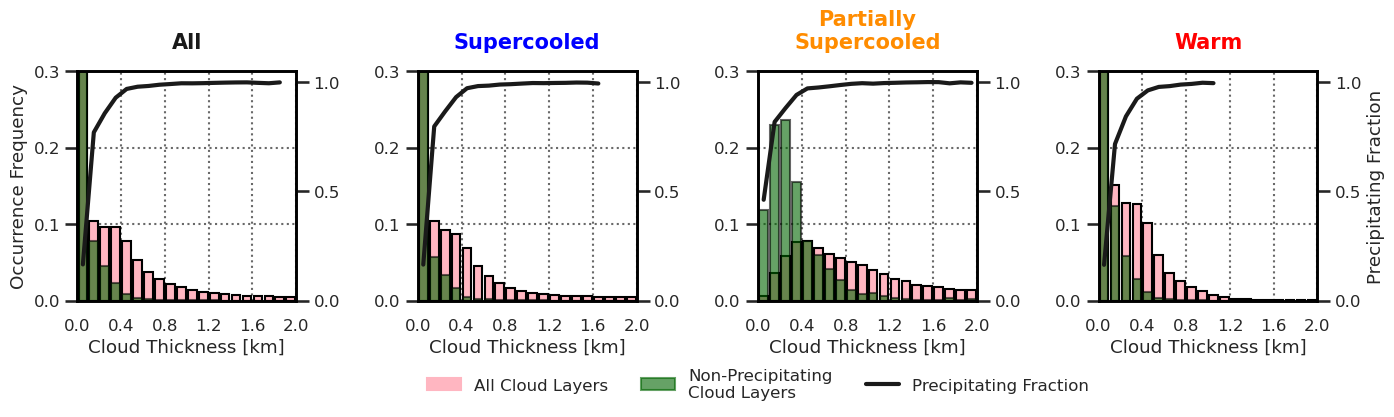

done


In [19]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Talks -- Histograms of Cloud Thickness
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')

#matplotlib.rcParams.update(matplotlib.rcParamsDefault)

pink_color = 'lightpink'
pink_edgecolor = 'black'
pink_alpha = 1
green_color = 'darkgreen'
green_edgecolor = 'black'
green_alpha = 0.6

Fontsize=12
dummult = 1.1

fig = plt.figure(figsize=(16,3))
gs=GridSpec(1,8) # 7 rows, 6 columns

# Cloud Depth
ax1 = fig.add_subplot(gs[0,0:2]) #row, column        
ax2 = fig.add_subplot(gs[0,2:4]) # row, column        
ax3 = fig.add_subplot(gs[0,4:6]) # row, column        
ax4 = fig.add_subplot(gs[0,6:8]) # row, column
axlist1 = [ax1,ax2,ax3,ax4]

ax1a = ax1.twinx()
ax2a = ax2.twinx()
ax3a = ax3.twinx()
ax4a = ax4.twinx()

axlist1a = [ax1a,ax2a,ax3a,ax4a]
for ax in axlist1a:
    ax.tick_params(labelsize=Fontsize)
    ax.set_ylim(0,1.05)
    ax.set_yticks([0,0.5,1])
    ax.grid(False)
ax4a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax1.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)


#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# Cloud Thickness
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
depth_bins = np.arange(0,8100,100)
depth_midbins = np.array([(depth_bins[ii] + depth_bins[ii+1])/2 for ii in range(len(depth_bins)-1)])
dum_depth_bins = np.arange(0,len(depth_bins))
dum_depth_midbins = np.array([(dum_depth_bins[ii] + dum_depth_bins[ii+1])/2 for ii in range(len(dum_depth_bins)-1)])

dumthick=0.8

#---------------------------
# Loop through fitlerings
#---------------------------



filter_type_list = ['all','supercooled','partially_supercooled','warm']
ii = 0
for ax in axlist1:
    filter_type = filter_type_list[ii]
    axa = axlist1a[ii]
    dumlim = 20
    var_precip, var_nonprecip, var_all = filter_data(precip_binary,cbt,ctt,c_thick,filter_type)       

    # All clouds
    samp_size_all = np.size(var_all)
    occur_freq_all,dumbins = occur_freq(var_all,depth_bins,samp_size_all)
    ax.bar(dum_depth_midbins[0:dumlim],occur_freq_all[0:dumlim],width=dumthick,label='All Layers',\
           color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor) 
    
    # Non-precipitating clouds
    samp_size_nonprecip = np.size(var_nonprecip)
    occur_freq_nonprecip,dumbins = occur_freq(var_nonprecip,depth_bins,samp_size_nonprecip)
    ax.bar(dum_depth_midbins[0:dumlim],occur_freq_nonprecip[0:dumlim],width=dumthick,label='Non-Precipitating Layers',\
           color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)
 
    
    # Precipitating Fraction
    pf = precip_frac(var_precip,var_all,depth_bins)
    pf[pf == 0.] = np.nan
    axa.plot(dum_depth_midbins[0:dumlim],pf[0:dumlim],lw=3,c='k')
    ax.set_xlabel('Cloud Thickness [km]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize)
    ax.grid(which='both',color='dimgrey',ls='dotted',lw=1.5)
    ax.set_xlim(0,dumlim)
    ax.set_ylim(0,0.3)
    ax.set_yticks([0,0.1,0.2,0.3])
    

    # Adjust axis ticks and labels
    ax.set_xticks(dum_depth_bins[0:dumlim+4:4])
    tmp_ticks = ax.get_xticks()
    #dum_labels = [(str(int(depth_bins[0:dumlim+2:2][dd]))) for dd in range(len(tmp_ticks))]
    dum_labels = [(str(depth_bins[0:dumlim+4:4][dd]*1.e-3)) for dd in range(len(tmp_ticks))]
    #ax.set_xticklabels(dum_labels,rotation=45,ha='center')
    ax.set_xticklabels(dum_labels,ha='center')
    
    ii+=1


#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# Closing annotations
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------


#ax1.text(-0.5,0.5,'Cloud Thickness',ha='center',va='center',\
#         fontweight='bold',fontsize=Fontsize*1.5,rotation=90,transform=ax1.transAxes)

#ax9.text(-0.2,0.5,'CTT',ha='center',va='center',\
#         fontweight='bold',fontsize=Fontsize*1.5,rotation=90,transform=ax9.transAxes)    

ax1.text(0.5,1.125,'All',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.25,transform=ax1.transAxes)   
ax2.text(0.5,1.125,'Supercooled',ha='center',va='center',color='blue',\
         fontweight='bold',fontsize=Fontsize*1.25,transform=ax2.transAxes)

ax3.text(0.5,1.175,'Partially\nSupercooled',ha='center',va='center',color='darkorange',\
         fontweight='bold',fontsize=Fontsize*1.25,transform=ax3.transAxes)

ax4.text(0.5,1.125,'Warm',ha='center',va='center',color='red',\
         fontweight='bold',fontsize=Fontsize*1.25,transform=ax4.transAxes)    



from matplotlib.lines import Line2D
color1_patch = mpatches.Patch(color=pink_color, label='All Cloud Layers',alpha=pink_alpha)
color2_patch = mpatches.Patch(color=green_color, label='Non-Precipitating\nCloud Layers',alpha=green_alpha)
dumline = Line2D([0],[0],c='k',lw=3,ls='solid',label='Precipitating Fraction')
ax3.legend(handles=[color1_patch,color2_patch,dumline],fontsize=Fontsize,\
           loc='lower center',bbox_to_anchor=(0.,-0.5),ncol=3,framealpha=False)    


plt.subplots_adjust(wspace=2.5,hspace=0.6,top=0.875)
#plt.suptitle('Occurrence Frequencies',fontweight='bold',fontsize=Fontsize*2.5)

plt.show()
plt.close()
print('done')

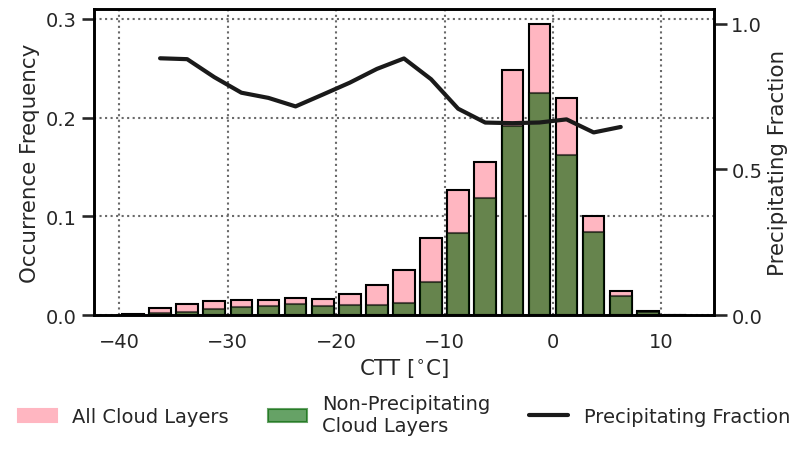

done


In [24]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Talks -- Histogram of CTT
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')

#matplotlib.rcParams.update(matplotlib.rcParamsDefault)

pink_color = 'lightpink'
pink_edgecolor = 'black'
pink_alpha = 1
green_color = 'darkgreen'
green_edgecolor = 'black'
green_alpha = 0.6

Fontsize=14
dummult = 1.1

fig = plt.figure(figsize=(8,4))

# Cloud Depth
ax = fig.add_subplot(111) #row, column      

# CTT
ax.set_xlabel('CTT [$^{\\circ}$C]',fontsize=Fontsize*dummult)
ax.tick_params(labelsize=Fontsize)
ax.grid(which='both',color='dimgrey',ls='dotted',lw=1.5)
axa = ax.twinx()
axa.tick_params(labelsize=Fontsize)
axa.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)
axa.set_ylim(0,1.05)
axa.set_yticks([0,0.5,1])
axa.grid(False)

#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# CTT
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------

ctt_bins = np.arange(-40,15,2.5)
ctt_midbins = np.array([(ctt_bins[ii] + ctt_bins[ii+1])/2 for ii in range(len(ctt_bins)-1)])  
  
dumthick=2.

precip_0 = np.where(precip_binary == 0.)
precip_1 = np.where(precip_binary == 1.)
all_id = np.where((precip_binary == 0.) | (precip_binary == 1.))
ctt_precip = ctt[precip_1]
ctt_nonprecip = ctt[precip_0]
ctt_all = ctt[all_id]
samp_size = np.size(precip_1)

occur_freq_all,dumbins = occur_freq(ctt_all,ctt_bins,samp_size) 
dumx = np.arange(1,len(ctt_midbins)+1,1)
ax.bar(ctt_midbins,occur_freq_all,width=dumthick,label='All Clouds',\
         color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor)

samp_size = np.size(precip_0)
occur_freq_nonprecip,dumbins = occur_freq(ctt_nonprecip,ctt_bins,samp_size)
ax.bar(ctt_midbins,occur_freq_nonprecip,width=dumthick,label='Non-Precipitating Clouds',\
         color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)

pf = precip_frac(ctt_precip,ctt_all,ctt_bins)
pf[pf == 0.] = np.nan
axa.plot(ctt_midbins[:-1],pf[:-1],lw=3,c='k')

ax.set_yticks([0,0.1,0.2,0.3])



from matplotlib.lines import Line2D
color1_patch = mpatches.Patch(color=pink_color, label='All Cloud Layers',alpha=pink_alpha)
color2_patch = mpatches.Patch(color=green_color, label='Non-Precipitating\nCloud Layers',alpha=green_alpha)
dumline = Line2D([0],[0],c='k',lw=3,ls='solid',label='Precipitating Fraction')
ax.legend(handles=[color1_patch,color2_patch,dumline],fontsize=Fontsize,\
           loc='lower center',bbox_to_anchor=(0.5,-0.45),ncol=3,framealpha=False)    


plt.subplots_adjust(wspace=2.5,hspace=0.6,top=0.875)
#plt.suptitle('Occurrence Frequencies',fontweight='bold',fontsize=Fontsize*2.5)

plt.show()
plt.close()
print('done')

In [34]:
#---------------------------------------------------------
#---------------------------------------------------------
#---------------------------------------------------------
# Fig. 4 -- Precipitating Fraction as a function of CTT and Cloud Thickness
#---------------------------------------------------------
#---------------------------------------------------------
#---------------------------------------------------------
#---------------------------------------------------------
dum_precip_binary = precip_binary.copy()
dum_ctt = ctt.copy()
dum_c_thick = c_thick.copy()
dum_ref_mean_bel = ref_mean_bel.copy()
dumid = np.where((dum_ctt > -38.) & (dum_c_thick > -999.) )
dum_ctt = dum_ctt[dumid]
dum_c_thick = dum_c_thick[dumid]
dum_precip_binary = dum_precip_binary[dumid]
dum_ref_mean_bel = dum_ref_mean_bel[dumid]
dumid = np.where( (dum_precip_binary == 1.) & (dum_ref_mean_bel < -36.) )
#print(np.size(dumid)/np.size(dum_precip_binary))
#dum_precip_binary[dumid] = 0.

dum_precip_binary_2 = precip_binary.copy()
dum_ctt_2 = ctt.copy()
dum_ref_mean_bel_2 = ref_mean_bel.copy()
dum_c_thick_2 = c_thick.copy()
dumid_2 = np.where((dum_ctt_2 > -38.) & (dum_c_thick_2 > -999.))
dum_ctt_2 = dum_ctt_2[dumid_2]
dum_c_thick_2 = dum_c_thick_2[dumid_2]
dum_precip_binary_2 = dum_precip_binary_2[dumid_2]
dum_ref_mean_bel_2 = dum_ref_mean_bel_2[dumid_2]
dumid_2 = np.where( (dum_precip_binary_2 == 1.) & (dum_ref_mean_bel_2 < -20.) )
dum_precip_binary_2[dumid_2] = 0.


sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"


# Joint histogram of CTT and Cloud Depth Precipitating Fraction
fig = plt.figure(figsize=(8.3,16.6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
Fontsize=20
ax1.set_xlabel('CTT [$^{\circ}$C]',fontsize=Fontsize)
ax2.set_xlabel('CTT [$^{\circ}$C]',fontsize=Fontsize)
ax1.set_ylabel('Cloud Thickness [km]',fontsize=Fontsize)
ax2.set_ylabel('Cloud Thickness [km]',fontsize=Fontsize)
ax1.tick_params(labelsize=Fontsize)
ax2.tick_params(labelsize=Fontsize)
#ax1.grid(which='both')

# Calculate precipitating fraction as a function of cloud depth and CTT

depth_bins = np.arange(0,2000,200)
depth_bins_2 = np.arange(2000,8000,1000)
depth_bins = np.concatenate((depth_bins,depth_bins_2))   
arb_bins = np.arange(0,len(depth_bins),1)

#ctt_bins = np.arange(-40,24,4)
ctt_bins = np.arange(-36,16,4)
dumbins = np.array([-38])
ctt_bins = np.concatenate((dumbins,ctt_bins))
ctt_midbins = np.array([(ctt_bins[ii] + ctt_bins[ii+1])/2 for ii in range(len(ctt_bins)-1)])     
arb_midbins = np.array([(arb_bins[ii] + arb_bins[ii+1])/2 for ii in range(len(arb_bins)-1)])     


precip_frac_bins = np.arange(0,1.05,0.05)
ctt_binsize = ctt_bins[2]-ctt_bins[1]
arb_binsize=1.


nipy = cm.get_cmap('inferno',len(precip_frac_bins))
newcolors = nipy(np.linspace(0,1,len(precip_frac_bins)))   

# Ze,thresh = -36.
numvec = np.zeros((len(ctt_bins)-1,len(depth_bins)-1))
for ii in range(len(ctt_bins)-1):
    for jj in range(len(depth_bins)-1):
        tmpid = np.where( (dum_ctt >= ctt_bins[ii]) & (dum_ctt < ctt_bins[ii+1]) & (dum_c_thick >= depth_bins[jj]) & (dum_c_thick < depth_bins[jj+1]) )
        numid = np.size(tmpid)
        dumsize = numid/np.size(precip_binary)*100.
        numvec[ii,jj] = dumsize
        if dumsize > 0.00001:
            ctt_lim = dum_ctt[tmpid]
            c_thick_lim = dum_c_thick[tmpid]
            precip_binary_lim = dum_precip_binary[tmpid]
            precip_0 = np.where(precip_binary_lim == 0)
            precip_1 = np.where(precip_binary_lim == 1)

            
            tmp_precip_frac = np.size(precip_binary_lim[precip_1])/np.size(precip_binary_lim)


            col = np.max(np.where(tmp_precip_frac >= precip_frac_bins))
            tmpplot = ax1.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                    facecolor=newcolors[col]))

        else:
            numvec[ii,jj] = 0
            tmpplot = ax1.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                   facecolor='black'))       


# Contour counts
cs = ax1.contour(ctt_midbins,arb_midbins,numvec.T,colors='black',\
            linewidths=3,levels=[0.1,0.5,1,5,10,50])

# Ze,thresh = -20.
numvec_2 = np.zeros((len(ctt_bins)-1,len(depth_bins)-1))
for ii in range(len(ctt_bins)-1):
    for jj in range(len(depth_bins)-1):
        tmpid = np.where( (dum_ctt_2 >= ctt_bins[ii]) & (dum_ctt_2 < ctt_bins[ii+1]) & (dum_c_thick_2 >= depth_bins[jj]) & (dum_c_thick_2 < depth_bins[jj+1]) )
        numid = np.size(tmpid)
        dumsize = numid/np.size(precip_binary_2)*100.
        numvec_2[ii,jj] = dumsize
        if dumsize > 0.00001:
            ctt_lim = dum_ctt_2[tmpid]
            c_thick_lim = dum_c_thick_2[tmpid]
            precip_binary_lim = dum_precip_binary_2[tmpid]
            precip_0 = np.where(precip_binary_lim == 0)
            precip_1 = np.where(precip_binary_lim == 1)

            
            tmp_precip_frac = np.size(precip_binary_lim[precip_1])/np.size(precip_binary_lim)


            col = np.max(np.where(tmp_precip_frac >= precip_frac_bins))
            tmpplot = ax2.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                    facecolor=newcolors[col]))

        else:
            numvec_2[ii,jj] = 0
            tmpplot = ax2.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                   facecolor='black'))       


# Contour counts
cs2 = ax2.contour(ctt_midbins,arb_midbins,numvec_2.T,colors='black',\
            linewidths=3,levels=[0.1,0.5,1,5,10,50])


ax1.clabel(cs,cs.levels,inline=True,fmt=fmt,fontsize=20)
ax2.clabel(cs2,cs2.levels,inline=True,fmt=fmt,fontsize=20)
ax1.set_xlim(-36,12)
ax2.set_xlim(-36,12)
#ax1.set_yscale('log')
#ax1.set_ylim(100,10000)    
ax1.set_ylim(0,len(depth_bins)-2) 
ax2.set_ylim(0,len(depth_bins)-2) 
ax1.set_yticks(arb_bins[::2])
ax2.set_yticks(arb_bins[::2])
labels = [str(np.around(depth_bins[::2][dd]*1.e-3,1)) for dd in range(len(depth_bins[::2]))]
ax1.set_yticklabels(labels)
ax2.set_yticklabels(labels)

#ax1.set_yticks(np.arange(0,16,2))
#tmp_depth_bins = depth_bins[0::2]

bounds = precip_frac_bins
norm = matplotlib.colors.BoundaryNorm(bounds,nipy.N)
ax99 = fig.add_axes([0.925,0.125,0.03,0.33])
cb = matplotlib.colorbar.ColorbarBase(ax99,cmap=nipy,norm=norm,\
                                  spacing='uniform',\
                                  ticks=bounds,\
                                  boundaries=bounds,
                                  orientation='vertical')
cb.set_ticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.])

ax98 = fig.add_axes([0.925,0.55,0.03,0.33])
cb2 = matplotlib.colorbar.ColorbarBase(ax98,cmap=nipy,norm=norm,\
                                  spacing='uniform',\
                                  ticks=bounds,\
                                  boundaries=bounds,
                                  orientation='vertical')
cb2.set_ticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.])

ax99.tick_params(labelsize=Fontsize)
ax98.tick_params(labelsize=Fontsize)
ax99.set_ylabel('Precipitating Fraction',fontsize=Fontsize)
ax98.set_ylabel('Precipitating Fraction',fontsize=Fontsize)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black',lw=4)]
dumcolor = 'blue'
dumbbox=dict(facecolor='lavender', alpha=0)
ax1.legend(custom_lines, ['% of Dataset'],fontsize=Fontsize,loc='upper right',framealpha=1)
ax2.legend(custom_lines, ['% of Dataset'],fontsize=Fontsize,loc='upper right',framealpha=1)
ax1.text(0.01,0.625,'$\\Delta$ = 200 m',fontsize=Fontsize*1.5,transform=ax1.transAxes,color=dumcolor,fontweight='bold',bbox=dumbbox)
ax2.text(0.01,0.625,'$\\Delta$ = 200 m',fontsize=Fontsize*1.5,transform=ax2.transAxes,color=dumcolor,fontweight='bold',bbox=dumbbox)
ax1.text(0.01,0.76,'$\\Delta$ = 1 km',fontsize=Fontsize*1.5,transform=ax1.transAxes,color=dumcolor,fontweight='bold',bbox=dumbbox)
ax2.text(0.01,0.76,'$\\Delta$ = 1 km',fontsize=Fontsize*1.5,transform=ax2.transAxes,color=dumcolor,fontweight='bold',bbox=dumbbox)
ax1.axhline(10,linewidth=5,c=dumcolor,ls='dashed')
ax2.axhline(10,linewidth=5,c=dumcolor,ls='dashed')
ax1.xaxis.tick_bottom()
ax2.xaxis.tick_bottom()
ax1.yaxis.tick_left()
ax2.yaxis.tick_left()
ax1.text(0,1.04,'(a) $Z_{e,min}$ = -36 dBZ',transform=ax1.transAxes,fontsize=Fontsize*1.75,ha='left')
#ax1.text(0.675,1.04,'$Z_{e,min}$ = -36 dBZ',transform=ax1.transAxes,fontsize=Fontsize*1.75,ha='right')
ax2.text(0,1.04,'(b) $Z_{e,min}$ = -20 dBZ',transform=ax2.transAxes,fontsize=Fontsize*1.75,ha='left')
#ax2.text(0.675,1.04,'$Z_{e,min}$ = -20 dBZ',transform=ax2.transAxes,fontsize=Fontsize*1.75,ha='right')
plt.subplots_adjust(hspace=0.3)
fig_path = '/home/mwstanfo/figures/micre_paper/'
#outfile = 'fig_04.png'
outfile = 'fig_04.eps'
plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
#plt.show()
plt.close()
print('done')

done


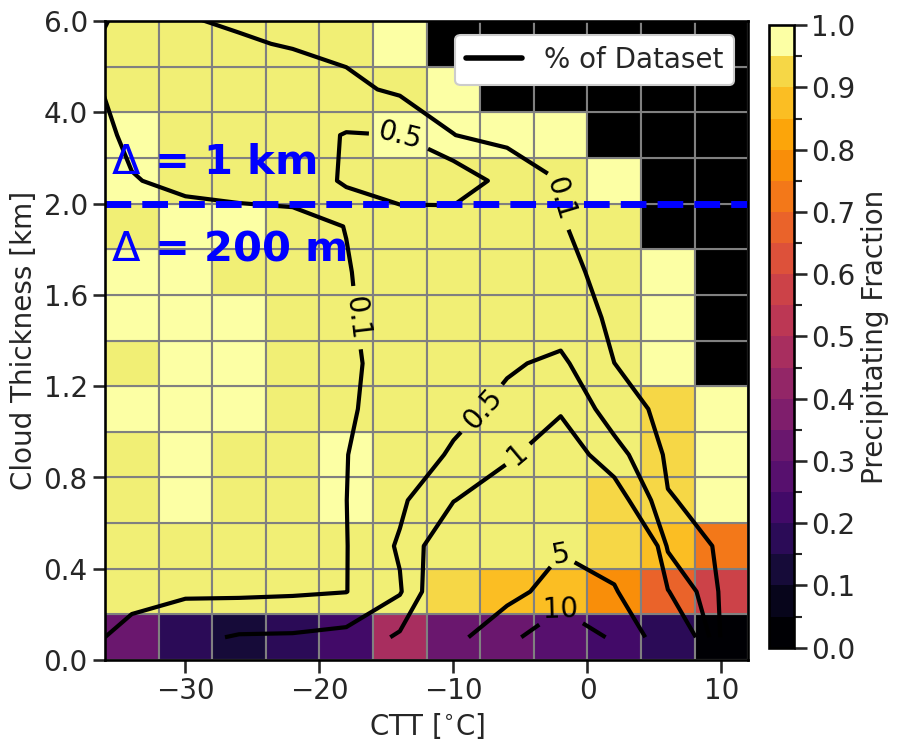

done


In [33]:
#---------------------------------------------------------
#---------------------------------------------------------
#---------------------------------------------------------
# Talks -- Precipitating Fraction as a function of CTT and Cloud Thickness
#---------------------------------------------------------
#---------------------------------------------------------
#---------------------------------------------------------
#---------------------------------------------------------
dum_precip_binary = precip_binary.copy()
dum_ctt = ctt.copy()
dum_c_thick = c_thick.copy()
dum_ref_mean_bel = ref_mean_bel.copy()
dumid = np.where((dum_ctt > -38.) & (dum_c_thick > -999.) )
dum_ctt = dum_ctt[dumid]
dum_c_thick = dum_c_thick[dumid]
dum_precip_binary = dum_precip_binary[dumid]
dum_ref_mean_bel = dum_ref_mean_bel[dumid]
dumid = np.where( (dum_precip_binary == 1.) & (dum_ref_mean_bel < -36.) )
sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"


# Joint histogram of CTT and Cloud Depth Precipitating Fraction
fig = plt.figure(figsize=(8.3,8.3))
ax1 = fig.add_subplot(111)
Fontsize=20
ax1.set_xlabel('CTT [$^{\circ}$C]',fontsize=Fontsize)
ax1.set_ylabel('Cloud Thickness [km]',fontsize=Fontsize)
ax1.tick_params(labelsize=Fontsize)

# Calculate precipitating fraction as a function of cloud depth and CTT

depth_bins = np.arange(0,2000,200)
depth_bins_2 = np.arange(2000,8000,1000)
depth_bins = np.concatenate((depth_bins,depth_bins_2))   
arb_bins = np.arange(0,len(depth_bins),1)

#ctt_bins = np.arange(-40,24,4)
ctt_bins = np.arange(-36,16,4)
dumbins = np.array([-38])
ctt_bins = np.concatenate((dumbins,ctt_bins))
ctt_midbins = np.array([(ctt_bins[ii] + ctt_bins[ii+1])/2 for ii in range(len(ctt_bins)-1)])     
arb_midbins = np.array([(arb_bins[ii] + arb_bins[ii+1])/2 for ii in range(len(arb_bins)-1)])     


precip_frac_bins = np.arange(0,1.05,0.05)
ctt_binsize = ctt_bins[2]-ctt_bins[1]
arb_binsize=1.


nipy = cm.get_cmap('inferno',len(precip_frac_bins))
newcolors = nipy(np.linspace(0,1,len(precip_frac_bins)))   

# Ze,thresh = -36.
numvec = np.zeros((len(ctt_bins)-1,len(depth_bins)-1))
for ii in range(len(ctt_bins)-1):
    for jj in range(len(depth_bins)-1):
        tmpid = np.where( (dum_ctt >= ctt_bins[ii]) & (dum_ctt < ctt_bins[ii+1]) & (dum_c_thick >= depth_bins[jj]) & (dum_c_thick < depth_bins[jj+1]) )
        numid = np.size(tmpid)
        dumsize = numid/np.size(precip_binary)*100.
        numvec[ii,jj] = dumsize
        if dumsize > 0.00001:
            ctt_lim = dum_ctt[tmpid]
            c_thick_lim = dum_c_thick[tmpid]
            precip_binary_lim = dum_precip_binary[tmpid]
            precip_0 = np.where(precip_binary_lim == 0)
            precip_1 = np.where(precip_binary_lim == 1)

            
            tmp_precip_frac = np.size(precip_binary_lim[precip_1])/np.size(precip_binary_lim)


            col = np.max(np.where(tmp_precip_frac >= precip_frac_bins))
            tmpplot = ax1.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                    facecolor=newcolors[col]))

        else:
            numvec[ii,jj] = 0
            tmpplot = ax1.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                   facecolor='black'))       


# Contour counts
cs = ax1.contour(ctt_midbins,arb_midbins,numvec.T,colors='black',\
            linewidths=3,levels=[0.1,0.5,1,5,10,50])


ax1.clabel(cs,cs.levels,inline=True,fmt=fmt,fontsize=20)
ax1.set_xlim(-36,12)
ax1.set_ylim(0,len(depth_bins)-2) 
ax2.set_ylim(0,len(depth_bins)-2) 
ax1.set_yticks(arb_bins[::2])
labels = [str(np.around(depth_bins[::2][dd]*1.e-3,1)) for dd in range(len(depth_bins[::2]))]
ax1.set_yticklabels(labels)

#ax1.set_yticks(np.arange(0,16,2))
#tmp_depth_bins = depth_bins[0::2]

bounds = precip_frac_bins
norm = matplotlib.colors.BoundaryNorm(bounds,nipy.N)
ax99 = fig.add_axes([0.925,0.125,0.03,0.75])
cb = matplotlib.colorbar.ColorbarBase(ax99,cmap=nipy,norm=norm,\
                                  spacing='uniform',\
                                  ticks=bounds,\
                                  boundaries=bounds,
                                  orientation='vertical')
cb.set_ticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.])


ax99.tick_params(labelsize=Fontsize)
ax99.set_ylabel('Precipitating Fraction',fontsize=Fontsize)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black',lw=4)]
dumcolor = 'blue'
dumbbox=dict(facecolor='lavender', alpha=0)
ax1.legend(custom_lines, ['% of Dataset'],fontsize=Fontsize,loc='upper right',framealpha=1)
ax1.text(0.01,0.625,'$\\Delta$ = 200 m',fontsize=Fontsize*1.5,transform=ax1.transAxes,color=dumcolor,fontweight='bold',bbox=dumbbox)
ax1.text(0.01,0.76,'$\\Delta$ = 1 km',fontsize=Fontsize*1.5,transform=ax1.transAxes,color=dumcolor,fontweight='bold',bbox=dumbbox)
ax1.axhline(10,linewidth=5,c=dumcolor,ls='dashed')
ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()
plt.subplots_adjust(hspace=0.3)

#fig_path = '/home/mwstanfo/figures/micre_paper/'
#outfile = 'fig_04.png'
#outfile = 'fig_04.eps'
#plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()
print('done')

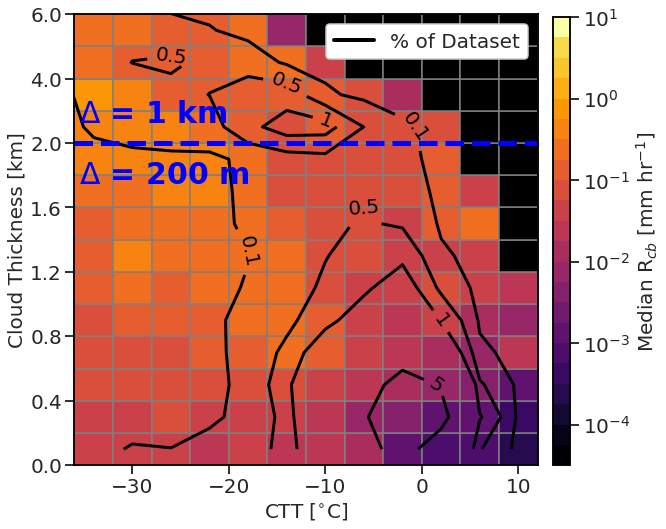

done


In [31]:
#---------------------------------------------------------
#---------------------------------------------------------
#---------------------------------------------------------
# Fig. 6 ---- Median Rcb as a function of CTT and Cloud Thickness
#---------------------------------------------------------
#---------------------------------------------------------
#---------------------------------------------------------
dum_rcb = rcb_orig.copy()
dum_ctt = ctt.copy()
dum_c_thick = c_thick.copy()
dumid = np.where((dum_rcb > -999.) & (dum_ctt > -38.) & (dum_c_thick > -999.))
dum_ctt = dum_ctt[dumid]
dum_c_thick = dum_c_thick[dumid]
dum_rcb = dum_rcb[dumid]

sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"


fig = plt.figure(figsize=(8.3,8.3))
ax1 = fig.add_subplot(111)
Fontsize=20
ax1.set_xlabel('CTT [$^{\circ}$C]',fontsize=Fontsize)
ax1.set_ylabel('Cloud Thickness [km]',fontsize=Fontsize)
ax1.tick_params(labelsize=Fontsize)

depth_bins = np.arange(0,2000,200)
depth_bins_2 = np.arange(2000,8000,1000)
depth_bins = np.concatenate((depth_bins,depth_bins_2))   
arb_bins = np.arange(0,len(depth_bins),1)

#ctt_bins = np.arange(-40,24,4)
ctt_bins = np.arange(-36,16,4)
dumbins = np.array([-38])
ctt_bins = np.concatenate((dumbins,ctt_bins))
ctt_midbins = np.array([(ctt_bins[ii] + ctt_bins[ii+1])/2 for ii in range(len(ctt_bins)-1)])     
arb_midbins = np.array([(arb_bins[ii] + arb_bins[ii+1])/2 for ii in range(len(arb_bins)-1)])     

rcb_bins = np.arange(-4.5,1.25,0.25)
rcb_binsize = 0.25    

ctt_binsize = ctt_bins[2]-ctt_bins[1]
arb_binsize=1.

nipy = cm.get_cmap('inferno',len(rcb_bins))
newcolors = nipy(np.linspace(0,1,len(rcb_bins)))   


# Ze,thresh = -36.
numvec = np.zeros((len(ctt_bins)-1,len(depth_bins)-1))
for ii in range(len(ctt_bins)-1):
    for jj in range(len(depth_bins)-1):
        tmpid = np.where( (dum_ctt >= ctt_bins[ii]) & (dum_ctt < ctt_bins[ii+1]) & (dum_c_thick >= depth_bins[jj]) & (dum_c_thick < depth_bins[jj+1]) & (dum_rcb > 0.))
        numid = np.size(tmpid)
        dumsize = numid/np.size(np.where(rcb > 0.))*100.
        numvec[ii,jj] = dumsize
        
        if dumsize > 0.0001:
            ctt_lim = dum_ctt[tmpid]
            c_thick_lim = dum_c_thick[tmpid]
            rcb_lim = dum_rcb[tmpid]
            
            med_rcb = np.nanmedian(np.log10(rcb_lim))
            col = np.max(np.where(med_rcb >= rcb_bins))

            tmpplot = ax1.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                        ctt_binsize,arb_binsize,\
                                        alpha=1,edgecolor='grey',\
                                        facecolor=newcolors[col]))


        else:
            numvec[ii,jj] = 0
            tmpplot = ax1.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                   facecolor='black'))       




# Contour counts
cs = ax1.contour(ctt_midbins,arb_midbins,numvec.T,colors='black',\
            linewidths=3,levels=[0.1,0.5,1,5,10])



ax1.clabel(cs,cs.levels,inline=True,fmt=fmt,fontsize=20)
ax1.set_xlim(-36,12)
ax1.set_ylim(0,len(depth_bins)-2) 
ax1.set_yticks(arb_bins[::2])
labels = [str(np.around(depth_bins[::2][dd]*1.e-3,1)) for dd in range(len(depth_bins[::2]))]
ax1.set_yticklabels(labels)

bounds = rcb_bins
norm = matplotlib.colors.BoundaryNorm(bounds,nipy.N)

ax99 = fig.add_axes([0.925,0.125,0.03,0.75])
cb = matplotlib.colorbar.ColorbarBase(ax99,cmap=nipy,norm=norm,\
                                  spacing='uniform',\
                                  ticks=bounds,\
                                  boundaries=bounds,
                                  orientation='vertical')
cb.set_ticks([-4,-3,-2,-1,0,1])
cb.set_ticklabels(['10$^{-4}$',\
                      '10$^{-3}$',\
                      '10$^{-2}$',\
                      '10$^{-1}$',\
                      '10$^{0}$',\
                      '10$^{1}$',\
                     ])

ax99.set_ylabel('Median R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)


ax99.tick_params(labelsize=Fontsize)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black',lw=4)]
dumcolor = 'blue'
dumbbox=dict(facecolor='lavender', alpha=0)
ax1.legend(custom_lines, ['% of Dataset'],fontsize=Fontsize,loc='upper right',framealpha=1)
ax1.text(0.01,0.625,'$\\Delta$ = 200 m',fontsize=Fontsize*1.5,transform=ax1.transAxes,color=dumcolor,fontweight='bold',bbox=dumbbox)
ax1.text(0.01,0.76,'$\\Delta$ = 1 km',fontsize=Fontsize*1.5,transform=ax1.transAxes,color=dumcolor,fontweight='bold',bbox=dumbbox)
ax1.axhline(10,linewidth=5,c=dumcolor,ls='dashed')
ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()
#ax1.text(0.,1.04,'(a)',transform=ax1.transAxes,fontsize=Fontsize*2,ha='right')
#ax1.text(0.675,1.04,'$Z_{e,thresh}$ = -36 dBZ',transform=ax1.transAxes,fontsize=Fontsize*1.75,ha='right')
fig_path = '/home/mwstanfo/figures/micre_paper/'
#outfile = 'fig_06.png'
outfile = 'fig_06.eps'
#plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()
print('done')

In [37]:
#---------------------------------------------------------
#---------------------------------------------------------
#---------------------------------------------------------
# Fig. 7 -- Evaporated Fraction as a Function of Cloud Macrophysics
#---------------------------------------------------------
#---------------------------------------------------------
#---------------------------------------------------------
#sns.set_style('darkgrid',{"axes.facecolor": "grey"})
sns.set_theme()
sns.set_style('ticks')
#sns.set_style('dark')
sns.set(rc={'axes.facecolor':'lavender','axes.edgecolor': 'black'})
sns.set_context('talk')

#matplotlib.rcParams.update(matplotlib.rcParamsDefault)


def calc_evap_frac(evap_var,precip_to_sfc_binary,var_bins):
    evap_frac = np.zeros(var_bins.size-1)
    perc = np.zeros(var_bins.size-1)
    for jj in range(var_bins.size-1):
        dumid = np.where( (evap_var >= var_bins[jj]) & (evap_var < var_bins[jj+1]) & (evap_var > -555.))
        perc[jj] = np.size(dumid)/np.size(evap_var[evap_var > -555.])*100.
        if perc[jj] > 0.05:
            dumid = np.squeeze(dumid)
            dumid2 = np.where(precip_to_sfc_binary[dumid] == 0)
            if np.size(dumid2) > 0.:
                dumid2 = np.squeeze(dumid2)
                tmp_evap_frac = np.size(dumid2)/np.size(precip_to_sfc_binary[dumid])
            else:
                tmp_evap_frac = np.nan
            evap_frac[jj] = tmp_evap_frac
        else:
            tmp_evap_frac = np.nan
            evap_frac[jj] = tmp_evap_frac

    return evap_frac,perc

#plt.style.use('seaborn-bright')
#sns.set_style('')



fig = plt.figure(figsize=(12,12))

gs=GridSpec(12,2) # 12 rows, 2 columns
ax1a = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1:3,0])

ax2a = fig.add_subplot(gs[4,0])
ax2 = fig.add_subplot(gs[5:7,0])       

ax3a = fig.add_subplot(gs[8,0]) 
ax3 = fig.add_subplot(gs[9:11,0])       

ax4a = fig.add_subplot(gs[0,1])
ax4 = fig.add_subplot(gs[1:3,1])

ax5a = fig.add_subplot(gs[4,1])
ax5 = fig.add_subplot(gs[5:7,1])       

ax6a = fig.add_subplot(gs[8,1]) 
ax6 = fig.add_subplot(gs[9:11,1])       


axlist = [ax1,ax2,ax3,ax4,ax5,ax6]
axlista = [ax1a,ax2a,ax3a,ax4a,ax5a,ax6a]
Fontsize=12




var_list = [evap_cth,evap_cbh,evap_c_thick,evap_ctt,evap_cbt,evap_sfc_rh]
xax_labels = ['CTH [m]','CBH [m]','Cloud Thickness [m]','CTT [$^{\\circ}$C]','CBT [$^{\\circ}$C]','Surface RH [%]']

cth_bins = np.arange(0,10200,200)
cbh_bins = np.arange(0,8200,200)
ctt_bins = np.arange(-60,22.5,2.5)
cbt_bins = np.arange(-60,22.5,2.5)
c_thick_bins = np.arange(0,8200,200)
sfc_rh_bins = np.arange(0,102.5,2.5)

bins_list = [cth_bins,cbh_bins,c_thick_bins,ctt_bins,cbt_bins,sfc_rh_bins]


ii = 0
for ax in axlist:

    axa = axlista[ii]
    dumvar = var_list[ii]
    dumvar_bins = bins_list[ii]
    dumvar_midbins = np.array([((dumvar_bins[dd] + dumvar_bins[dd+1])/2.) for dd in range(len(dumvar_bins)-1)])
    
    # All Layers
    evap_frac,perc = calc_evap_frac(dumvar,evap_precip_to_sfc_binary,dumvar_bins)
    ax.plot(dumvar_midbins,evap_frac,lw=2,c='k')
    
    # Supercooled layers
    dumid = np.where( (evap_cbt < 0.) & (evap_ctt < 0.))
    if np.size(dumid) > 0.:
        dumid = np.squeeze(dumid)
        dum_evap_precip_to_sfc_binary = evap_precip_to_sfc_binary[dumid]
        dumvar2 = dumvar[dumid]
        evap_frac,perc = calc_evap_frac(dumvar2,dum_evap_precip_to_sfc_binary,dumvar_bins)
        ax.plot(dumvar_midbins,evap_frac,lw=2,c='blue')
    # Partially Supercooled layers
    dumid = np.where( (evap_cbt >= 0.) & (evap_ctt < 0.) )
    if np.size(dumid) > 0.:
        dumid = np.squeeze(dumid)
        dum_evap_precip_to_sfc_binary = evap_precip_to_sfc_binary[dumid]
        dumvar2 = dumvar[dumid]
        evap_frac,perc = calc_evap_frac(dumvar2,dum_evap_precip_to_sfc_binary,dumvar_bins)
        ax.plot(dumvar_midbins,evap_frac,lw=2,c='darkorange')    
   # Warm 
    dumid = np.where( (evap_cbt >= 0.) & (evap_ctt >= 0.) )
    if np.size(dumid) > 0.:
        dumid = np.squeeze(dumid)
        dum_evap_precip_to_sfc_binary = evap_precip_to_sfc_binary[dumid]
        dumvar2 = dumvar[dumid]
        evap_frac,perc = calc_evap_frac(dumvar2,dum_evap_precip_to_sfc_binary,dumvar_bins)
        ax.plot(dumvar_midbins,evap_frac,lw=2,c='red')      
        
    # Contribution to Evaporated Fraction
    contr_supercooled_out,contr_warm_out,contr_partially_supercooled_out = calc_contribution_to_evap_frac(dumvar,evap_precip_to_sfc_binary,dumvar_bins,evap_cbt,evap_ctt)
    axa.plot(dumvar_midbins,contr_supercooled_out,lw=2,c='blue')
    axa.plot(dumvar_midbins,contr_partially_supercooled_out,lw=2,c='darkorange')
    axa.plot(dumvar_midbins,contr_warm_out,lw=2,c='red')
    
    



    
    ii+=1
    


ax1.set_xscale('log')
ax1a.set_xscale('log')
ax2.set_xscale('log')
ax2a.set_xscale('log')
ax3.set_xscale('log')
ax3a.set_xscale('log')




jj=0
for jj in range(len(axlist)):
    ax = axlist[jj]
    ax.grid(which='both')
    ax.tick_params(labelsize=Fontsize)
    #ax.set_xlabel(xax_labels[jj],fontsize=Fontsize)
    ax.set_ylim(0,1.05)
    
    axa = axlista[jj]
    axa.set_ylim(0,1.05)
    axa.xaxis.set_label_position('top') 
    axa.xaxis.tick_top()
    ax.xaxis.tick_bottom()
    axa.tick_params(labelsize=Fontsize)
    ax.grid(True,axis='both',which='both')
    axa.grid(True,axis='both',which='both')
    axa.set_yticks([0,0.5,1])
    dumvar_bins = bins_list[jj]
    dumvar_midbins = np.array([((dumvar_bins[dd] + dumvar_bins[dd+1])/2.) for dd in range(len(dumvar_bins)-1)])
    
    jj+=1
    

ax1.set_ylabel('Evaporated\nFraction',fontsize=Fontsize)
ax2.set_ylabel('Evaporated\nFraction',fontsize=Fontsize)
ax3.set_ylabel('Evaporated\nFraction',fontsize=Fontsize)

ax1a.set_ylabel('Relative\nContribution',fontsize=Fontsize)
ax2a.set_ylabel('Relative\nContribution',fontsize=Fontsize)
ax3a.set_ylabel('Relative\nContribution',fontsize=Fontsize)

dumstr_list = ['(a) CTH [m]','(c) CBH [m]','(e) Cloud Thickness [m]','(b) CTT [$^{\\circ}$C]','(d) CBT [$^{\\circ}$C]','(f) RH$_{sfc}$ [%]']

ax1a.text(-0.15,1.795,dumstr_list[0],fontsize=Fontsize*1.75,transform=ax1a.transAxes)
ax2a.text(-0.15,1.795,dumstr_list[1],fontsize=Fontsize*1.75,transform=ax2a.transAxes)
ax3a.text(-0.15,1.9,dumstr_list[2],fontsize=Fontsize*1.75,transform=ax3a.transAxes)
ax4a.text(-0.05,1.85,dumstr_list[3],fontsize=Fontsize*1.75,transform=ax4a.transAxes)
ax5a.text(-0.05,1.81,dumstr_list[4],fontsize=Fontsize*1.75,transform=ax5a.transAxes)
ax6a.text(-0.05,1.85,dumstr_list[5],fontsize=Fontsize*1.75,transform=ax6a.transAxes)

ax1.set_xlim(300,7000)
ax1a.set_xlim(300,7000)
ax2.set_xlim(300,7000)
ax2a.set_xlim(300,7000)
ax3.set_xlim(100,7000)
ax3a.set_xlim(100,7000)
ax4.set_xlim(-38,10)
ax4a.set_xlim(-38,10)
ax5.set_xlim(-35,15)
ax5a.set_xlim(-35,15)
ax6.set_xlim(60,100)
ax6a.set_xlim(60,100)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black',lw=2),\
                Line2D([0], [0], color='blue',lw=2),\
                Line2D([0], [0], color='darkorange',lw=2),\
                Line2D([0], [0], color='red',lw=2),\
               ]
ax3.legend(custom_lines, ['All','Supercooled','Partially Supercooled','Warm',],\
           fontsize=Fontsize*1.2,loc='lower center',framealpha=0,\
          bbox_to_anchor=(1.075,-1),ncol=2,facecolor='white')

    
plt.subplots_adjust(hspace=0.6,wspace=0.115)
fig_path = '/home/mwstanfo/figures/micre_paper/'
#outfile = 'fig_07.png'
outfile = 'fig_07.eps'
plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
#plt.show()
plt.close()
print('done')

done


In [41]:
#---------------------------------------------------------
#---------------------------------------------------------
#---------------------------------------------------------
# Fig. 8 --- Evaporated Fraction Joint Histograms
#---------------------------------------------------------
#---------------------------------------------------------
#---------------------------------------------------------
dum_rcb = rcb_orig.copy()
dum_ctt = ctt.copy()
dum_c_thick = c_thick.copy()
dumid = np.where((dum_rcb > -999.) & (dum_ctt > -999.) & (dum_c_thick > -999.))
dum_ctt = dum_ctt[dumid]
dum_c_thick = dum_c_thick[dumid]
dum_rcb = dum_rcb[dumid]

sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"


fig = plt.figure(figsize=(8.3,16.6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
Fontsize=20
ax1.set_xlabel('CTT [$^{\circ}$C]',fontsize=Fontsize)
ax2.set_xlabel('RH$_{sfc}$ [%]',fontsize=Fontsize)
ax1.set_ylabel('Cloud Thickness [km]',fontsize=Fontsize)
ax2.set_ylabel('CBH [km]',fontsize=Fontsize)
ax1.tick_params(labelsize=Fontsize)
ax2.tick_params(labelsize=Fontsize)



# Calculate evaporated fraction as a function of cloud depth and CTT

depth_bins = np.arange(0,2000,200)
depth_bins_2 = np.arange(2000,8000,1000)
depth_bins = np.concatenate((depth_bins,depth_bins_2))   
arb_bins = np.arange(0,len(depth_bins),1)

ctt_bins = np.arange(-40,24,4)
ctt_midbins = np.array([(ctt_bins[ii] + ctt_bins[ii+1])/2 for ii in range(len(ctt_bins)-1)])     
arb_midbins = np.array([(arb_bins[ii] + arb_bins[ii+1])/2 for ii in range(len(arb_bins)-1)])     


evap_frac_bins = np.arange(0,1.05,0.05)
ctt_binsize = ctt_bins[1]-ctt_bins[0]
arb_binsize=1.




nipy = cm.get_cmap('inferno',len(evap_frac_bins))
newcolors = nipy(np.linspace(0,1,len(evap_frac_bins)))   
numvec = np.zeros((len(ctt_bins)-1,len(depth_bins)-1))

for ii in range(len(ctt_bins)-1):
    for jj in range(len(depth_bins)-1):
        tmpid = np.where( (evap_ctt >= ctt_bins[ii]) & (evap_ctt < ctt_bins[ii+1]) & (evap_c_thick >= depth_bins[jj]) & (evap_c_thick < depth_bins[jj+1]))
        numid = np.size(tmpid)
        dumsize = numid/np.size(evap_ctt)*100.
        numvec[ii,jj] = dumsize
        if dumsize > 0.001:
            ctt_lim = evap_ctt[tmpid]
            c_thick_lim = evap_c_thick[tmpid]
            precip_to_sfc_binary_lim = evap_precip_to_sfc_binary[tmpid]
            evap_0 = np.where(precip_to_sfc_binary_lim == 1.)
            evap_1 = np.where(precip_to_sfc_binary_lim == 0.)

            tmp_evap_frac = np.size(evap_1)/( np.size(evap_0) + np.size(evap_1))

            col = np.max(np.where(tmp_evap_frac >= evap_frac_bins))
            tmpplot = ax1.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                    facecolor=newcolors[col]))

        else:
            numvec[ii,jj] = 0
            tmpplot = ax1.add_patch(Rectangle((ctt_bins[ii],arb_bins[jj]),\
                                    ctt_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                   facecolor='black'))       




# Contour counts
cs = ax1.contour(ctt_midbins,arb_midbins,numvec.T,colors='grey',\
            linewidths=3,levels=[0.1,0.5,1,5,10,50])

ax1.clabel(cs,cs.levels,inline=True,fmt=fmt,fontsize=20)
ax1.set_xlim(-36,12) 
ax1.set_ylim(0,len(depth_bins)-2) 
ax1.set_yticks(arb_bins[::2])
labels = [str(np.around(depth_bins[::2][dd]*1.e-3,1)) for dd in range(len(depth_bins[::2]))]
ax1.set_yticklabels(labels)


# Calculate evaporated fraction as a function of CBH and RH

cbh_bins = np.arange(0,2000,200)
cbh_bins_2 = np.arange(2000,8000,1000)
cbh_bins = np.concatenate((cbh_bins,cbh_bins_2))   
arb_bins = np.arange(0,len(cbh_bins),1)

rh_bins = np.arange(50,104,4)
rh_midbins = np.array([(rh_bins[ii] + rh_bins[ii+1])/2 for ii in range(len(rh_bins)-1)])     
arb_midbins = np.array([(arb_bins[ii] + arb_bins[ii+1])/2 for ii in range(len(arb_bins)-1)])     


evap_frac_bins = np.arange(0,1.05,0.05)
rh_binsize = rh_bins[1]-rh_bins[0]
arb_binsize=1.




nipy = cm.get_cmap('inferno',len(evap_frac_bins))
newcolors = nipy(np.linspace(0,1,len(evap_frac_bins)))   
numvec = np.zeros((len(rh_bins)-1,len(cbh_bins)-1))

for ii in range(len(rh_bins)-1):
    for jj in range(len(cbh_bins)-1):
        tmpid = np.where( (evap_sfc_rh >= rh_bins[ii]) & (evap_sfc_rh < rh_bins[ii+1]) & (evap_cbh >= cbh_bins[jj]) & (evap_cbh < cbh_bins[jj+1]))
        numid = np.size(tmpid)
        dumsize = numid/np.size(evap_sfc_rh)*100.
        numvec[ii,jj] = dumsize
        if dumsize > 0.000001:
            rh_lim = evap_sfc_rh[tmpid]
            cbh_lim = evap_cbh[tmpid]
            precip_to_sfc_binary_lim = evap_precip_to_sfc_binary[tmpid]
            evap_0 = np.where(precip_to_sfc_binary_lim == 1.)
            evap_1 = np.where(precip_to_sfc_binary_lim == 0.)

            tmp_evap_frac = np.size(evap_1)/( np.size(evap_0) + np.size(evap_1))

            col = np.max(np.where(tmp_evap_frac >= evap_frac_bins))
            tmpplot = ax2.add_patch(Rectangle((rh_bins[ii],arb_bins[jj]),\
                                    rh_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                    facecolor=newcolors[col]))

        else:
            numvec[ii,jj] = 0
            tmpplot = ax2.add_patch(Rectangle((rh_bins[ii],arb_bins[jj]),\
                                    rh_binsize,arb_binsize,\
                                    alpha=1,edgecolor='grey',\
                                   facecolor='black'))       




# Contour counts
cs = ax2.contour(rh_midbins,arb_midbins,numvec.T,colors='grey',\
            linewidths=3,levels=[0.1,0.5,1,5,10,50])

ax2.clabel(cs,cs.levels,inline=True,fmt=fmt,fontsize=20)
#ax1.set_xlim(-40,12) 
ax2.set_xlim(50,100)
#ax2.set_ylim(0,len(cbh_bins)-1) 
ax2.set_ylim(0,len(cbh_bins)-2) 
ax2.set_yticks(arb_bins[::2])
labels = [str(np.around(cbh_bins[::2][dd]*1.e-3,1)) for dd in range(len(cbh_bins[::2]))]
ax2.set_yticklabels(labels)


bounds = evap_frac_bins
norm = matplotlib.colors.BoundaryNorm(bounds,nipy.N)
ax99 = fig.add_axes([0.925,0.125,0.03,0.33])
cb = matplotlib.colorbar.ColorbarBase(ax99,cmap=nipy,norm=norm,\
                                  spacing='uniform',\
                                  ticks=bounds,\
                                  boundaries=bounds,
                                  orientation='vertical')
cb.set_ticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.])

ax98 = fig.add_axes([0.925,0.55,0.03,0.33])
cb2 = matplotlib.colorbar.ColorbarBase(ax98,cmap=nipy,norm=norm,\
                                  spacing='uniform',\
                                  ticks=bounds,\
                                  boundaries=bounds,
                                  orientation='vertical')
cb2.set_ticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.])

ax99.tick_params(labelsize=Fontsize)
ax98.tick_params(labelsize=Fontsize)
ax99.set_ylabel('Evaporated Fraction',fontsize=Fontsize)
ax98.set_ylabel('Evaporated Fraction',fontsize=Fontsize)



from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='grey',lw=4)]
dumcolor = 'blue'
dumbbox=dict(facecolor='lavender', alpha=0)
ax1.legend(custom_lines, ['% of Dataset'],fontsize=Fontsize,loc='upper right',framealpha=1)
ax2.legend(custom_lines, ['% of Dataset'],fontsize=Fontsize,loc='upper right',framealpha=1)
ax1.text(0.01,0.625,'$\\Delta$ = 200 m',fontsize=Fontsize*1.5,transform=ax1.transAxes,color=dumcolor,fontweight='bold',bbox=dumbbox)
ax2.text(0.01,0.625,'$\\Delta$ = 200 m',fontsize=Fontsize*1.5,transform=ax2.transAxes,color=dumcolor,fontweight='bold',bbox=dumbbox)
ax1.text(0.01,0.76,'$\\Delta$ = 1 km',fontsize=Fontsize*1.5,transform=ax1.transAxes,color=dumcolor,fontweight='bold',bbox=dumbbox)
ax2.text(0.01,0.76,'$\\Delta$ = 1 km',fontsize=Fontsize*1.5,transform=ax2.transAxes,color=dumcolor,fontweight='bold',bbox=dumbbox)
ax1.axhline(10,linewidth=5,c=dumcolor,ls='dashed')
ax2.axhline(10,linewidth=5,c=dumcolor,ls='dashed')
ax1.xaxis.tick_bottom()
ax2.xaxis.tick_bottom()
ax1.yaxis.tick_left()
ax2.yaxis.tick_left()
ax1.text(-0.15,1.04,'(a) CTT-Cloud Thickness',transform=ax1.transAxes,fontsize=Fontsize*2,ha='left')
#ax1.text(0.675,1.04,'$Z_{e,min}$ = -36 dBZ',transform=ax1.transAxes,fontsize=Fontsize*1.75,ha='right')
ax2.text(-0.15,1.04,'(b) RH$_{sfc}$-CBH',transform=ax2.transAxes,fontsize=Fontsize*2,ha='left')
#ax2.text(0.675,1.04,'$Z_{e,min}$ = -20 dBZ',transform=ax2.transAxes,fontsize=Fontsize*1.75,ha='right')
plt.subplots_adjust(hspace=0.3)
fig_path = '/home/mwstanfo/figures/micre_paper/'
#outfile = 'fig_08.png'
outfile = 'fig_08.eps'
plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
#plt.show()
plt.close()
print('done')
#print(aaaaaa)

done
